# Homework 1 (Due Feb. 10, 2023 at Noon) 

Submit your solution notebook in your directory via github PR.

## Problem 1 (50 pts)

###  Fitting a Line using a Maximum Likelihood Estimator

Last week, you implcitly fitted straight lines with methods of moments estimators (i.e. sample mean and variance) and L-estimators (median and IQR). Generally though, we want some kind of uncertainty estimate for our models, and therefore M-estimators and maximum likelihood estimators in particular are useful.

Assume the scatter in our measurements (the residuals) is generated by a gaussian process i.e.:

>$ y_i = a x_i + b + r_i $

where $r_i$ is drawn from $N(0, \sigma)$. Here, $\sigma$ is the error the measurement induces.

To use an M-estimator/MLE, you have to specify the likelihood function. First, the probability $p(y_i|x_i, M(a, b), \sigma)$ that a particular point $y_i$ would be measured is just the normal distribution:

>$ p(y_i|x_i, M(a, b), \sigma) = N(y_i - M(x)|\sigma) = \frac{1}{\sqrt{2 \pi \sigma^2}} \exp \left( - \frac{(y_i - M(x_i))^2}{2 \sigma^2} \right) $.

Given what we discussed in class, we can write down the $\ln L$

>$ \ln L(a, b) = constant - \frac{1}{2 \sigma^2} \sum_{i=1}^N (y_i - M(x_i))^2 $

This is the expression that we now minimize with respect to $a$ and $b$ to find ML estimators for those parameters. 


And as we discussed in class, this is equivalent to minimizing the sum of the squares or a _least-squares method_.

## MLE with outliers

Let's apply the MLE to data with uncertainties where these uncertainties include outliers. 
I've defined a dataset below:

Your mission is to:

- write a function that computes the squared loss, and incorporates the uncertainties on the measurements, $dy$ (10 pts)
- Fit a line to the full sample by evaluating this likelihood on a grid of a, b (10 pts)
- Use sigma-clipping or an L-estimator for outlier rejection and fit a line to the data with outliers rejected (10 pts) and make a QQ plot of the residuals (10 pts)
- Define a new likelihood function that implements the Huber loss, also incorporating the measurement uncertainties $dy$ (10 pts)
- Fit a new line to all of the data (no outlier rejection) with the new Huber likelihod, except now use scipy.optimize.fmin instead of a grid search, and you know the drill by now - QQ plot of the residuals (10 pts)

Recommended reading: David Hogg, Jo Bovy, and Dustin Lang: "Data analysis recipes: Fitting a model to data", 2010: https://arxiv.org/abs/1008.4686

In [1]:
%matplotlib inline

In [2]:
import numpy as np
from matplotlib import pyplot as plt
import scipy.optimize
import statsmodels.api as sm
from astroML.datasets import fetch_hogg2010test
from astropy.stats import sigma_clip
from statsmodels.api import qqplot
from astropy.stats import knuth_bin_width

# this just makes plots a bit easier on my laptop - disable as needed
%config InlineBackend.figure_format='retina'

#------------------------------------------------------------
# Get data: this includes outliers
data = fetch_hogg2010test()
x = data['x']
y = data['y']
dy = data['sigma_y']

#### 1.) Write a function that computes the squared loss, and incorporates the uncertainties on the measurements,  𝑑𝑦  (10 pts)

For a linear model, the squared loss (divided by 2 to make it syngeristic with its derivative) is 
\begin{equation}
\rho\left(y - (mx + b)\right) = \frac{\left(y - (mx + b)\right)^2}{2}
\end{equation}
Incorporating uncertainties on the measurements (e.g. more uncertain measurements get lower weight than less uncertain weight), 
\begin{equation}
\rho\left(\frac{y - (mx + b)}{dy}\right) = \frac{1}{2}\left(\frac{y - (mx + b)}{dy}\right)^2
\end{equation}

In [3]:
def squared_loss(x, y, dy, m, b):
    return 0.5*((y-m*x-b)/dy)**2

#### 2.) Fit a line to the full sample by evaluating this likelihood on a grid of a, b (10 pts)

First, inspect the data

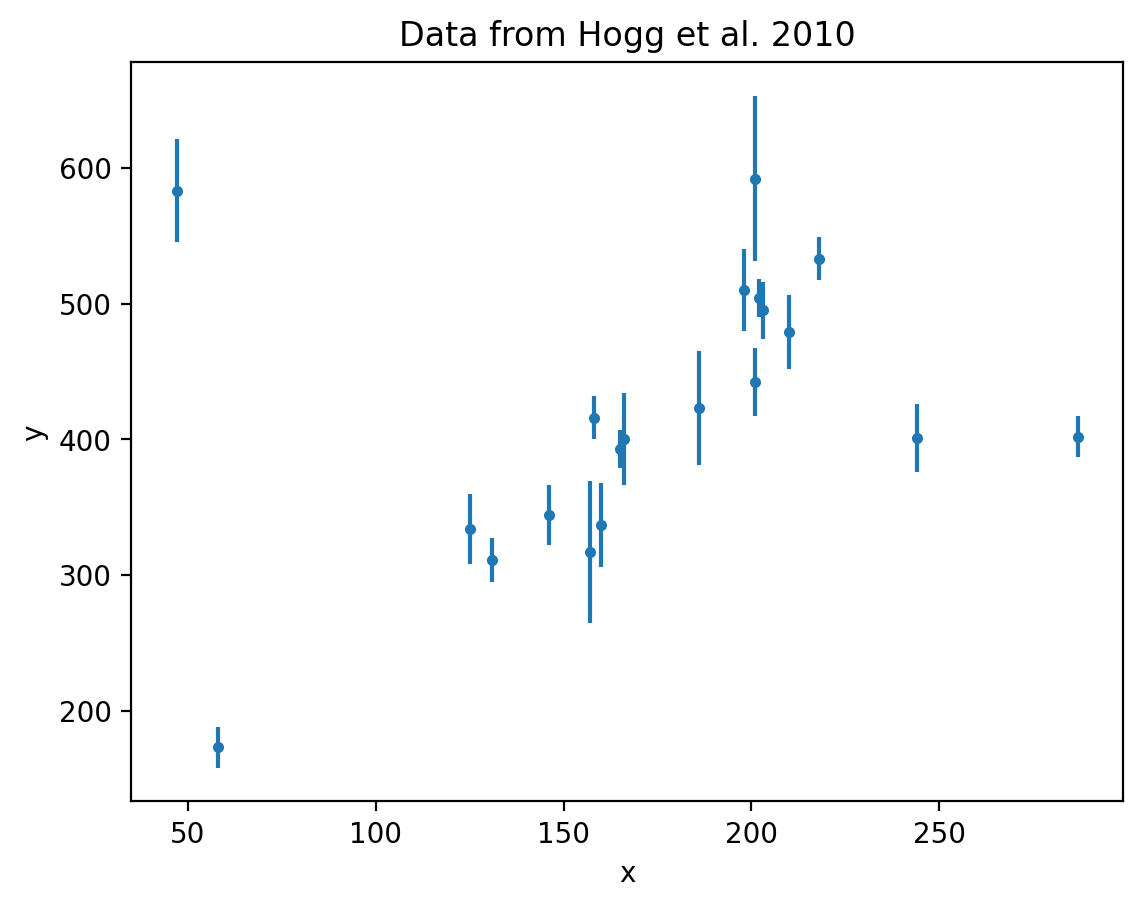

In [4]:
# Inspect the data to get a 0th order guess on the slope and intercept
plt.figure()
plt.errorbar(x, y, yerr=dy, fmt='.')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Data from Hogg et al. 2010')
plt.show()

The slope here is definitely positive, let's take (x, y) = (150, 300) and (200, 450) as some points that we might reasonably expect a fit to pass through. Then,
\begin{equation}
m_{\text{guess}} = \frac{450-300}{200-150} = 3 \\
y - 300 = 3(x - 150) \rightarrow b_{\text{guess}} = -150
\end{equation}


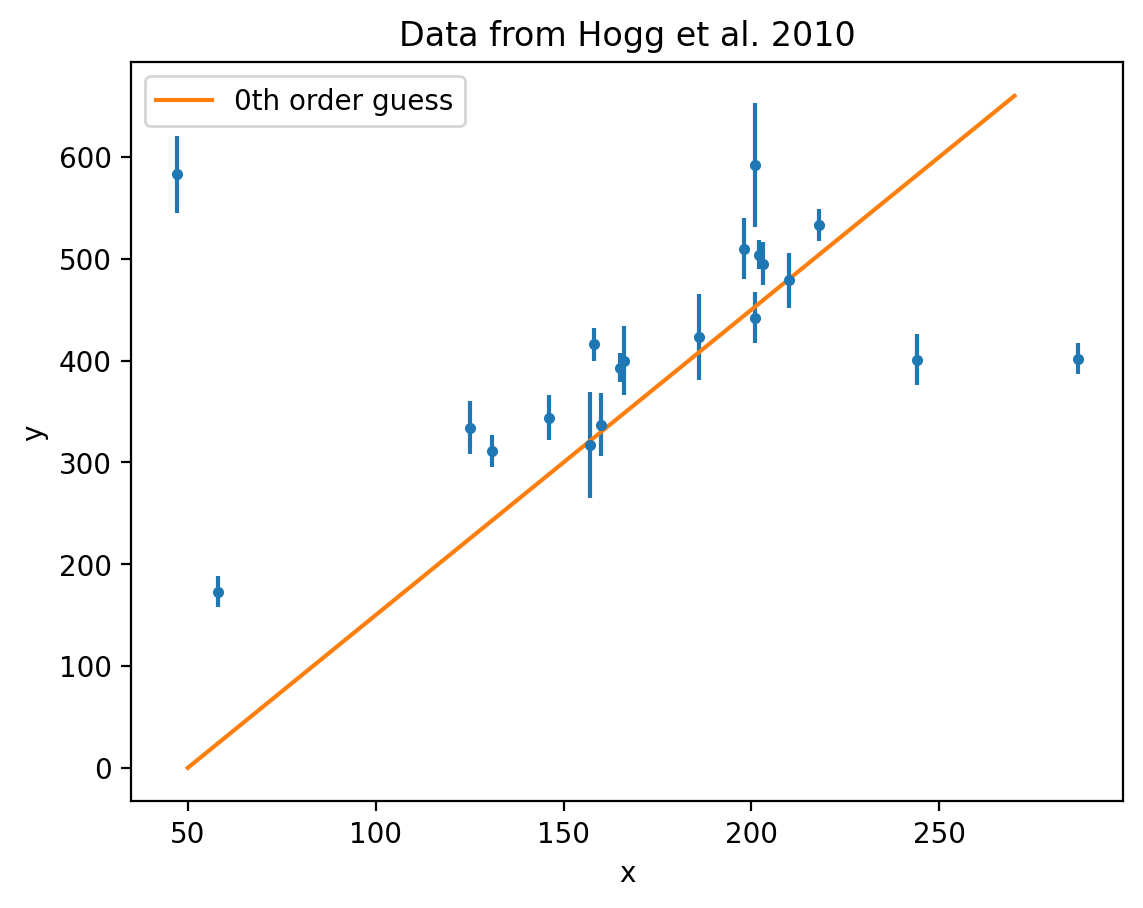

In [5]:
# Inspect the data to get a 0th order guess on the slope and intercept
plt.figure()
plt.errorbar(x, y, yerr=dy, fmt='.')
x_arr = np.linspace(50, 270, 10)
plt.plot(x_arr, 3*x_arr - 150, label='0th order guess')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Data from Hogg et al. 2010')
plt.legend()
plt.show()

This is a reasonable starting point. Next, we'll make a grid over which to compute likelihoods.

In [6]:
slopes, intercepts = np.mgrid[0:2:250j, -200:400:250j]

The log likelihood given a model of the form $H\left(\theta_i\right)$ = m$_i$ x + b$_i$ and observations $\vec{y}$:

\begin{equation}
\log L\left(m, b; \vec{y}\right) = -\frac{1}{2} \sum_k 2\pi\sigma_k^2 - \frac{1}{2}\sum_k \left(\frac{y_k - m x_k - b}{\sigma_k}\right)^2
\end{equation}

<!-- \begin{equation}
\log L = - \frac{1}{2}\sum_i 2 \pi \sigma_i^2 - \frac{1}{2}\sum_i \frac{y - H\left(\theta_i\right)}{\sigma_i^2}
\end{equation} -->

In [7]:
summed_squared_loss = lambda model_pair : np.sum(squared_loss(x, y, dy, model_pair[0], model_pair[1]))

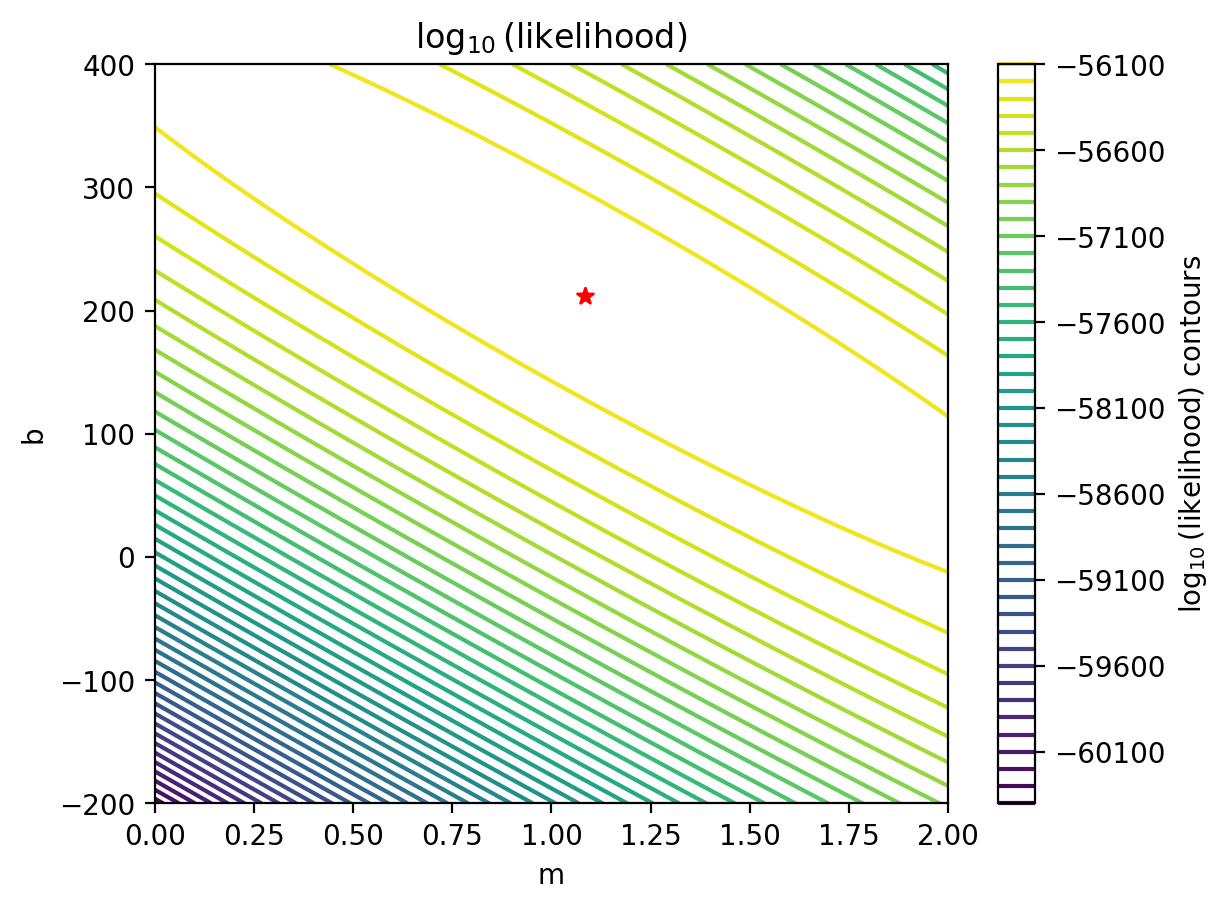

In [8]:
log_likelihood = -0.5*(np.sum(2*np.pi*dy**2) +\
                       [[summed_squared_loss((s,i)) for s in slopes[:,0]] for i in intercepts[0]])
plt.contour(slopes[:,0], intercepts[0], log_likelihood,
           levels=50)
plt.colorbar(label=r'$\log_{10}$(likelihood) contours')
plt.xlabel('m')
plt.ylabel('b')
plt.title(r'$\log_{10}$(likelihood)')
maxL_intercept_index, maxL_slope_index = np.where(log_likelihood == np.max(log_likelihood))
best_fit_slope = slopes[:,0][maxL_slope_index[0]]
best_fit_intercept = intercepts[0][maxL_intercept_index[0]]
plt.scatter(best_fit_slope, best_fit_intercept,marker='*',c='r')

The star on the log likelihood plot shows the slope-intercept pair that corresponds to the maximum likelihood on the grid. The plot below shows this fit against the data:

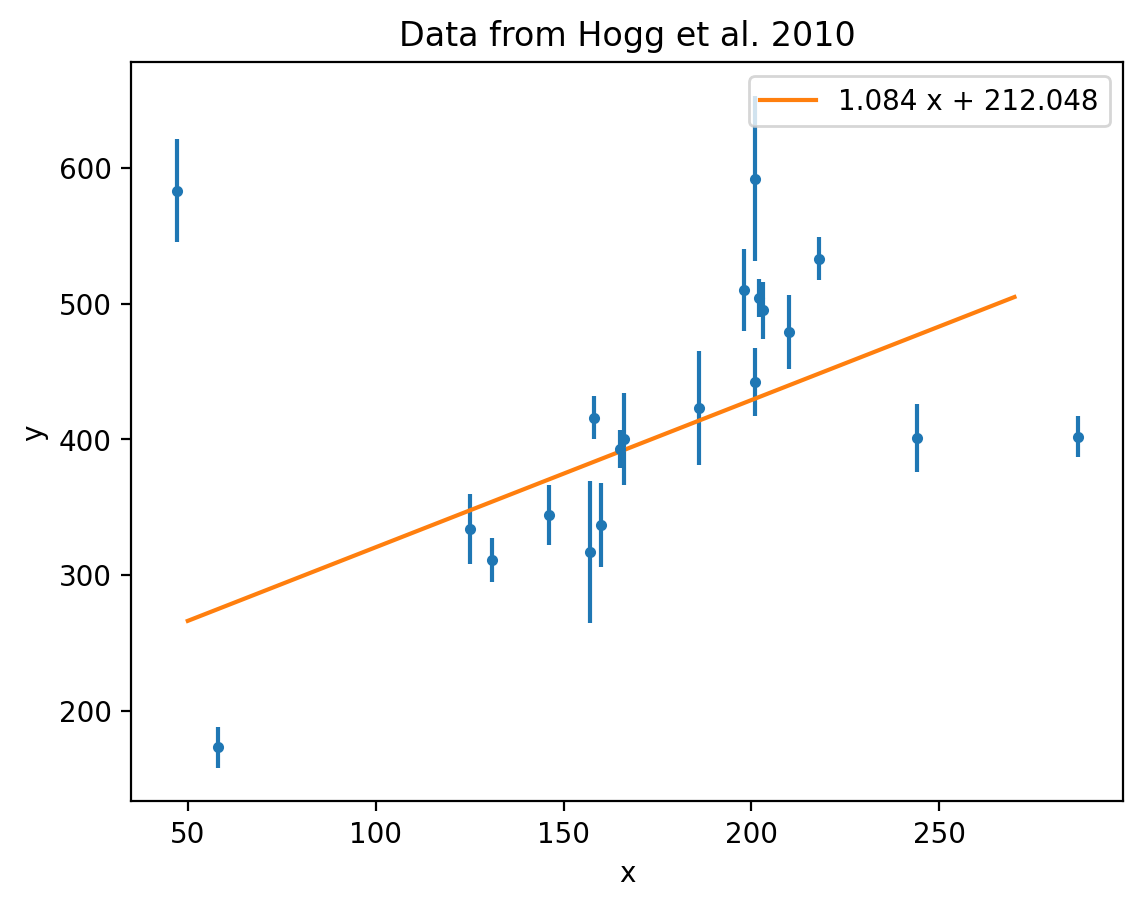

In [9]:
plt.figure()
plt.errorbar(x, y, yerr=dy, fmt='.')
x_arr = np.linspace(50, 270, 10)
plt.plot(x_arr, 
         best_fit_slope*x_arr + best_fit_intercept, 
         label='{:.3f} x + {:.3f}'.format(best_fit_slope, 
                                   best_fit_intercept))
plt.xlabel('x')
plt.ylabel('y')
plt.title('Data from Hogg et al. 2010')
plt.legend()
plt.show()

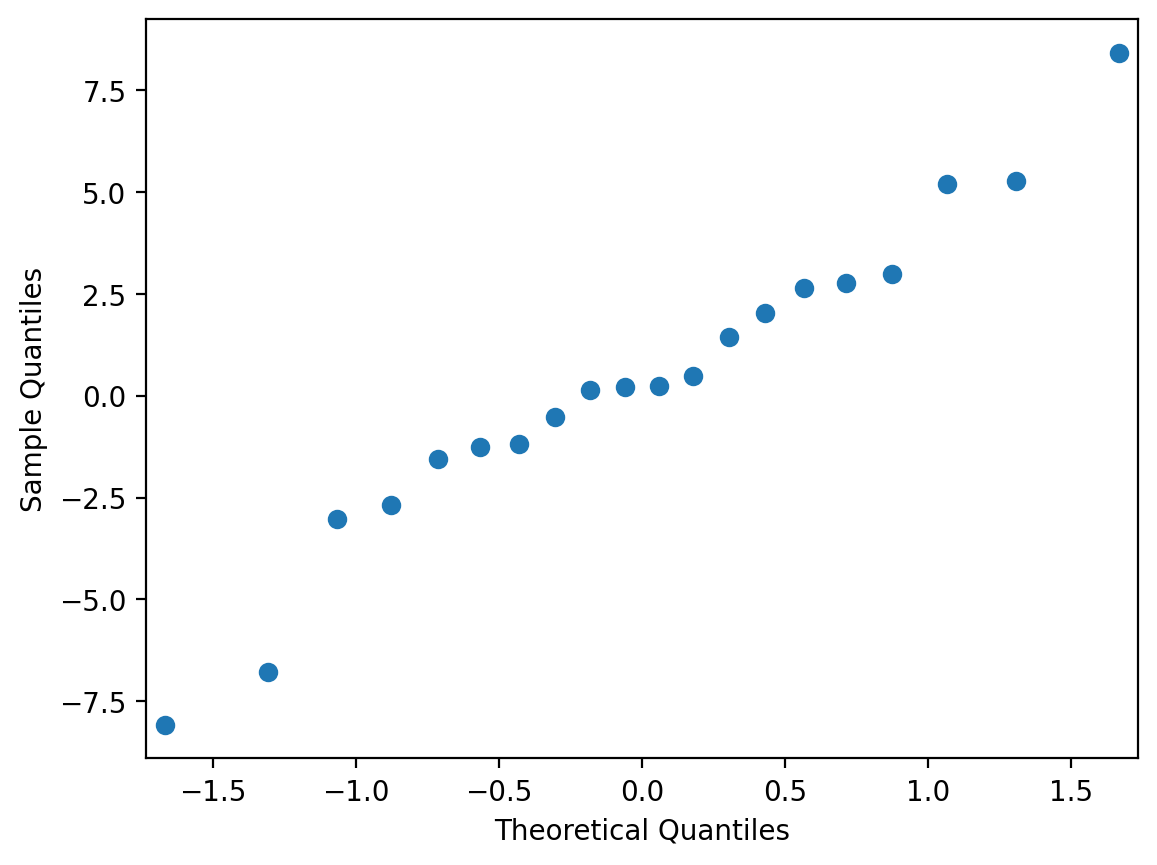

In [10]:
qqplot((y - (best_fit_slope*x + best_fit_intercept))/dy);

The figure above is the QQ plot of the residuals for this fit. The residuals seem to sample a normal distribution fairly well for the most part (sample and theoretical quantiles are $\sim$ linearly related), but there are some (5) outliers.

#### 3.) Use sigma-clipping or an L-estimator for outlier rejection and fit a line to the data with outliers rejected (10 pts) and make a QQ plot of the residuals (10 pts)

Let's try IQR, an L-estimator. To proceed, we'll take the residual (scaled by associated uncertainties) from the fit found in the previous case and reject points outside of the IQR from the next fit.

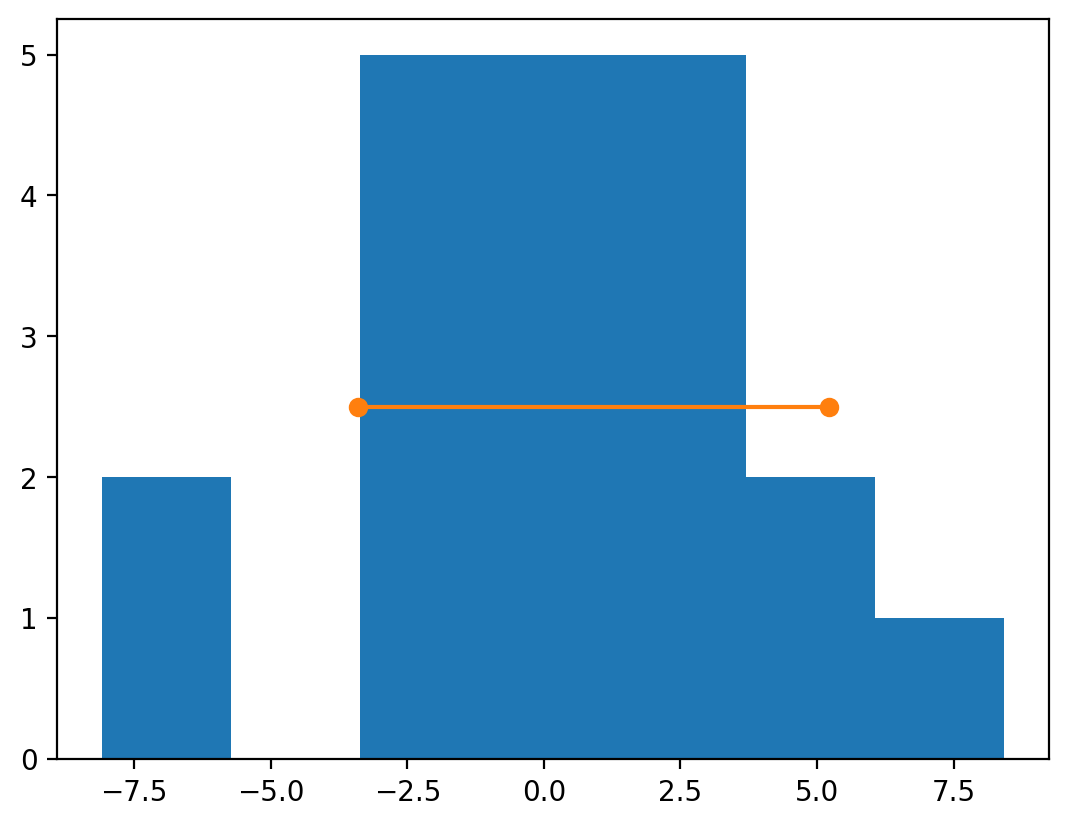

In [11]:
# Define the 90th and 10th percentiles
resid = (y - (best_fit_slope*x + best_fit_intercept))/dy
q10, q90 = np.percentile(resid, 10), np.percentile(resid, 90)
n_bins = int(np.round((np.max(resid)-np.min(resid))/knuth_bin_width(resid)))
plt.hist(resid, bins=n_bins)
plt.plot([q10, q90], [2.5, 2.5],'o-')

The IQR here is between the 10th and 90th percentiles.

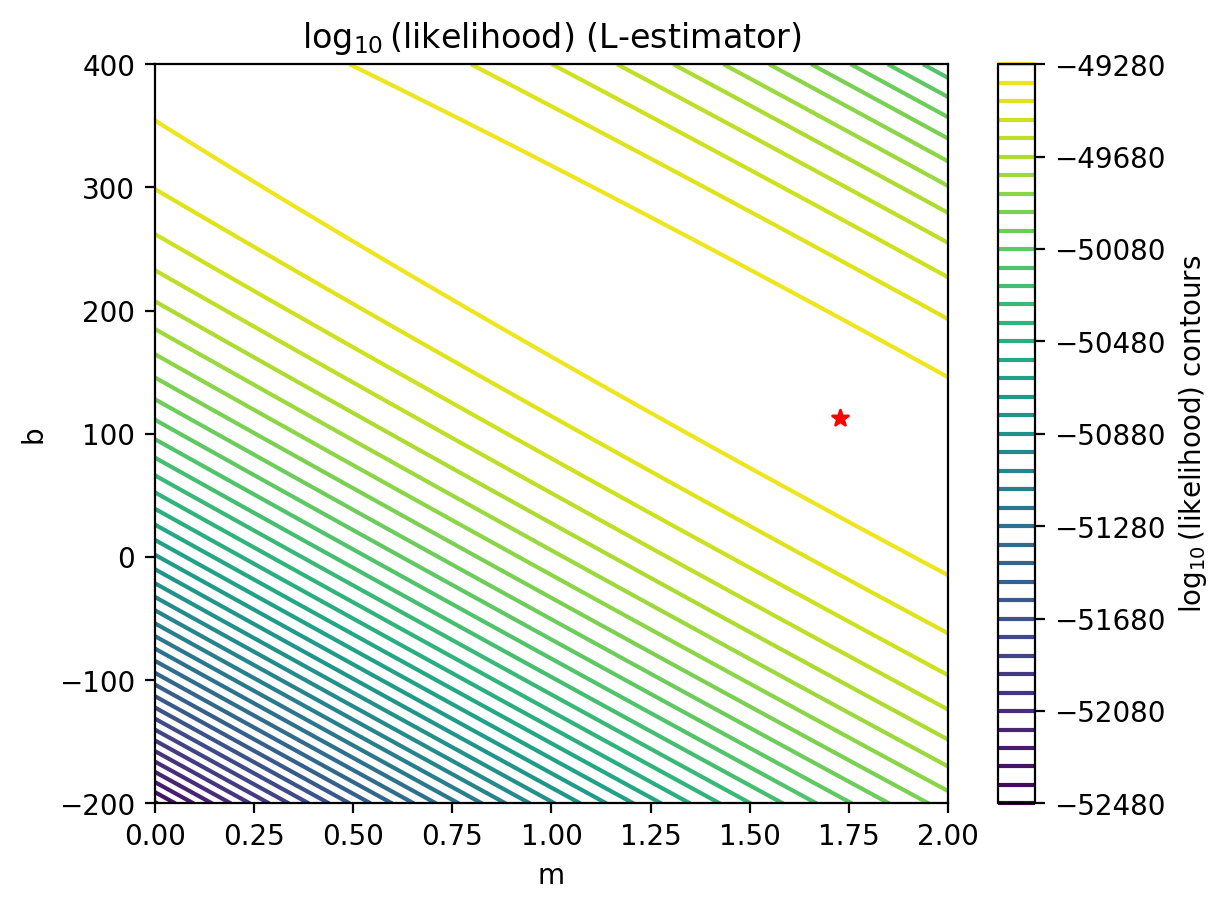

In [12]:
mask = (resid > q10) & (resid < q90)
summed_squared_loss_trim_outliers = lambda model_pair : np.sum(squared_loss(x[mask], 
                                                                            y[mask],
                                                                            dy[mask],
                                                                            model_pair[0], model_pair[1]))
log_likelihood_trim_outliers = -0.5*(np.sum(2*np.pi*dy[mask]**2) +\
                       [[summed_squared_loss_trim_outliers((s,i)) for s in slopes[:,0]] for i in intercepts[0]])
plt.contour(slopes[:,0], intercepts[0], log_likelihood_trim_outliers,
           levels=50)
plt.colorbar(label=r'$\log_{10}$(likelihood) contours')
plt.xlabel('m')
plt.ylabel('b')
plt.title(r'$\log_{10}$(likelihood) (L-estimator)')
maxL_intercept_index_Lest, maxL_slope_index_Lest = np.where(log_likelihood_trim_outliers ==\
                                                  np.max(log_likelihood_trim_outliers))
best_fit_slope_Lest = slopes[:,0][maxL_slope_index_Lest[0]]
best_fit_intercept_Lest = intercepts[0][maxL_intercept_index_Lest[0]]
plt.scatter(best_fit_slope_Lest, best_fit_intercept_Lest,marker='*',c='r')

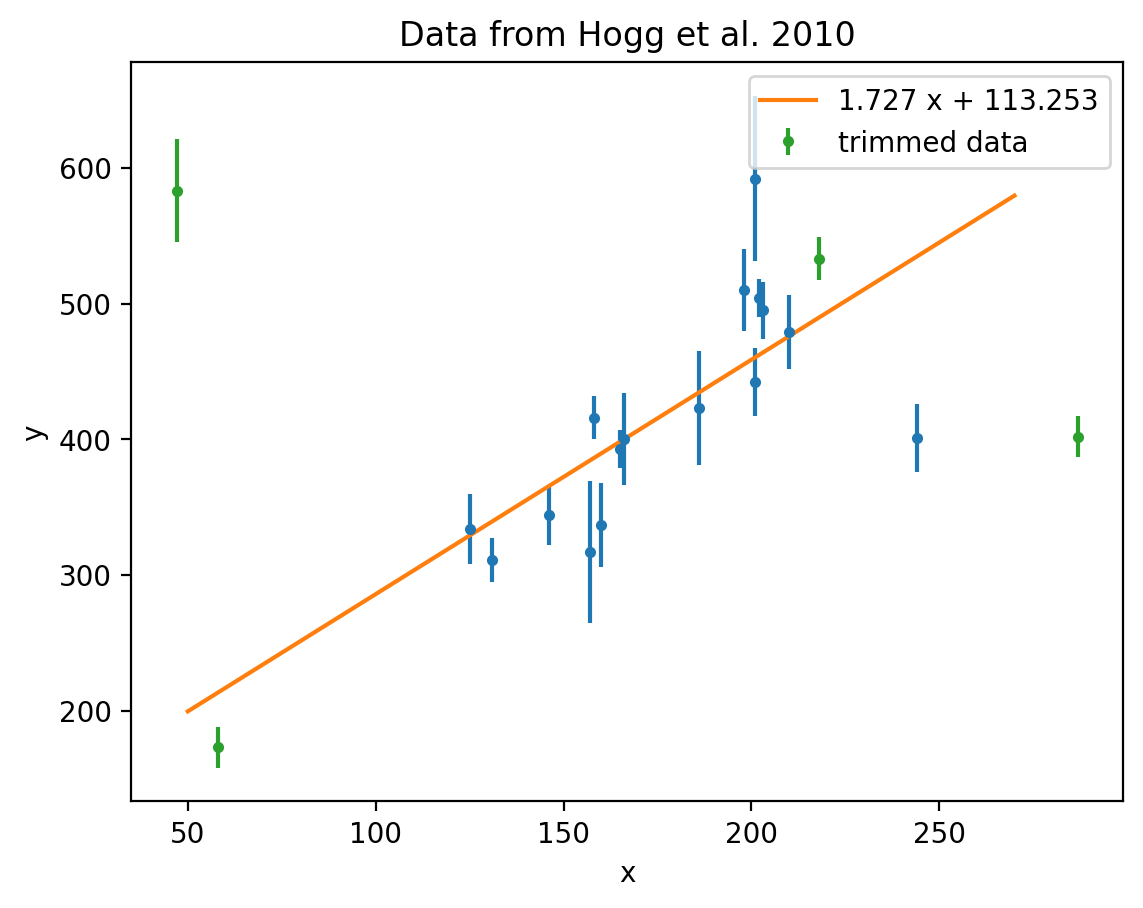

In [13]:
plt.figure()
plt.errorbar(x[mask], y[mask], yerr=dy[mask], fmt='.')
x_arr = np.linspace(50, 270, 10)
plt.plot(x_arr, 
         best_fit_slope_Lest*x_arr + best_fit_intercept_Lest, 
         label='{:.3f} x + {:.3f}'.format(best_fit_slope_Lest, 
                                   best_fit_intercept_Lest))
plt.errorbar(x[~mask], y[~mask], yerr=dy[~mask], fmt='.',label='trimmed data')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Data from Hogg et al. 2010')
plt.legend()
plt.show()

In the figure above, the green points are those excluded from the fit via the IQR L-estimator

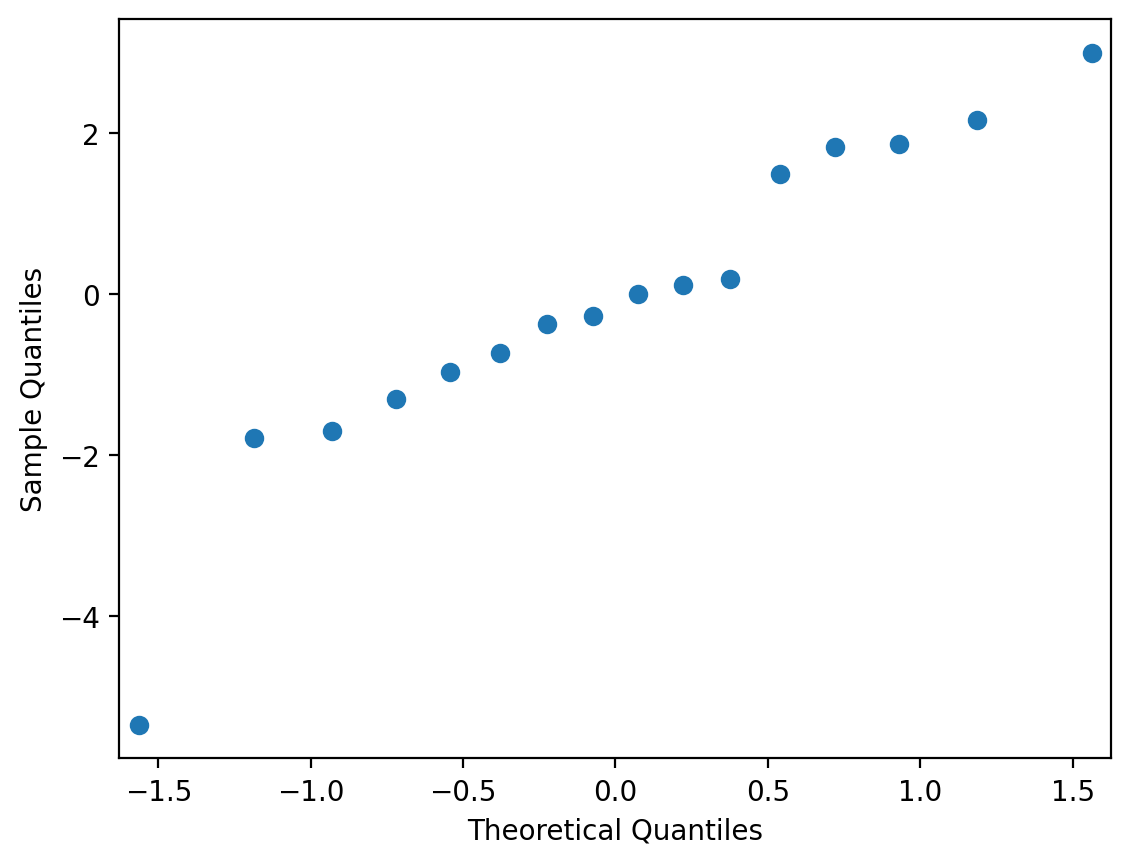

In [14]:
qqplot((y[mask] - (best_fit_slope_Lest*x[mask] + best_fit_intercept_Lest))/dy[mask]);

The figure above is the QQ plot of the residuals. While the L-estimator did leave some outlier residuals, this QQ plot shows a more linear fit than the fitting performed without outlier trimming.

#### 4.) Define a new likelihood function that implements the Huber loss, also incorporating the measurement uncertainties  𝑑𝑦  (10 pts)

Huber loss:
\begin{equation}
\rho_{\delta}(u) = \begin{cases}
    \frac{u^2}{2}, & \text{if } |u| \leq \delta.\\
    \delta \left(|u| - \frac{\delta}{2}\right), & \text{otherwise}.
  \end{cases}
\end{equation}

In [15]:
def huber_loss(x, y, dy, m, b, delta):
    residual = (y - (m*x + b))/dy
    loss = np.ones_like(residual)
    condition = abs(residual) <= delta
    loss[condition] = 0.5*(residual[condition])**2
    loss[~condition] = delta*(abs(residual[~condition]) - 0.5*delta)
    return loss

If the aim of using a different loss function is to be more robust to outliers, we should pick $\delta$ so that the non-outlier part of the data is still treated to a parabolic loss function and the outliers get the non-parabolic part of the piecewise function. We can do this by eye, or do it qualitatively, for example, setting $\delta$ to something of order the IQR of residuals.

90-10 IQR = 5.6932253298909945
75-25 IQR = 3.233248128992397


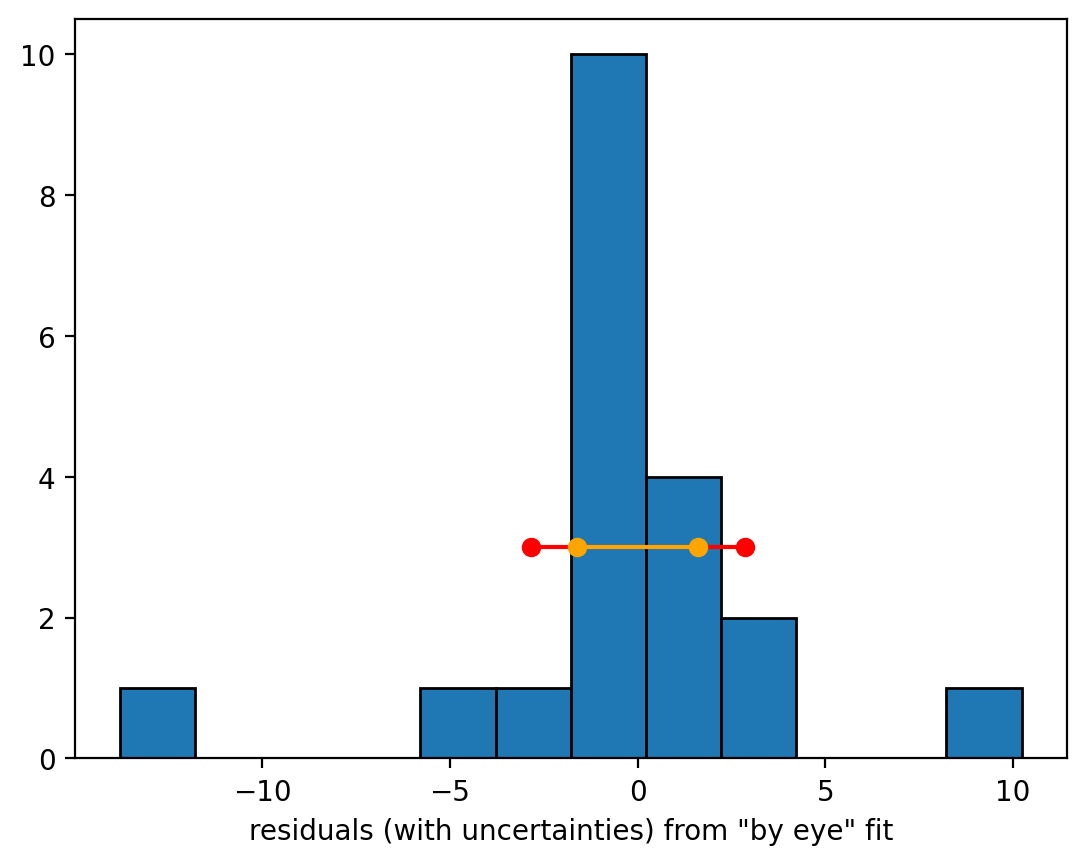

In [16]:
residuals2hist = (y - (best_fit_slope_Lest*x+best_fit_intercept_Lest))/dy
n_bins = int(np.round((np.max(residuals2hist)-np.min(residuals2hist))/knuth_bin_width(residuals2hist)))
plt.hist(residuals2hist, bins = n_bins,edgecolor='k')
plt.xlabel('residuals (with uncertainties) from "by eye" fit')
iqr = np.percentile(residuals2hist, 90) - np.percentile(residuals2hist, 10)
print('90-10 IQR = {}'.format(iqr))
plt.plot([-iqr/2, iqr/2], [3,3],'o-',c='r')
iqr = np.percentile(residuals2hist, 75) - np.percentile(residuals2hist, 25)
plt.plot([-iqr/2, iqr/2], [3,3],'o-',c='orange')
print('75-25 IQR = {}'.format(iqr))

In [17]:
5.6932253298909945/2

2.8466126649454973

The red line above is the 90\% - 10\% range, orange is 75\% - 25\%. 90\% - 10\% looks pretty robust to outliers. Since the piecewise function cares about the absolute value of the residual, we'll set $\delta$ to 2.85, around half the 90-10 IQR

In [18]:
summed_huber_loss = lambda model_pair, huber_delta : np.sum(huber_loss(x, 
                                                                       y, 
                                                                       dy, 
                                                                       model_pair[0], 
                                                                       model_pair[1], 
                                                                       huber_delta))

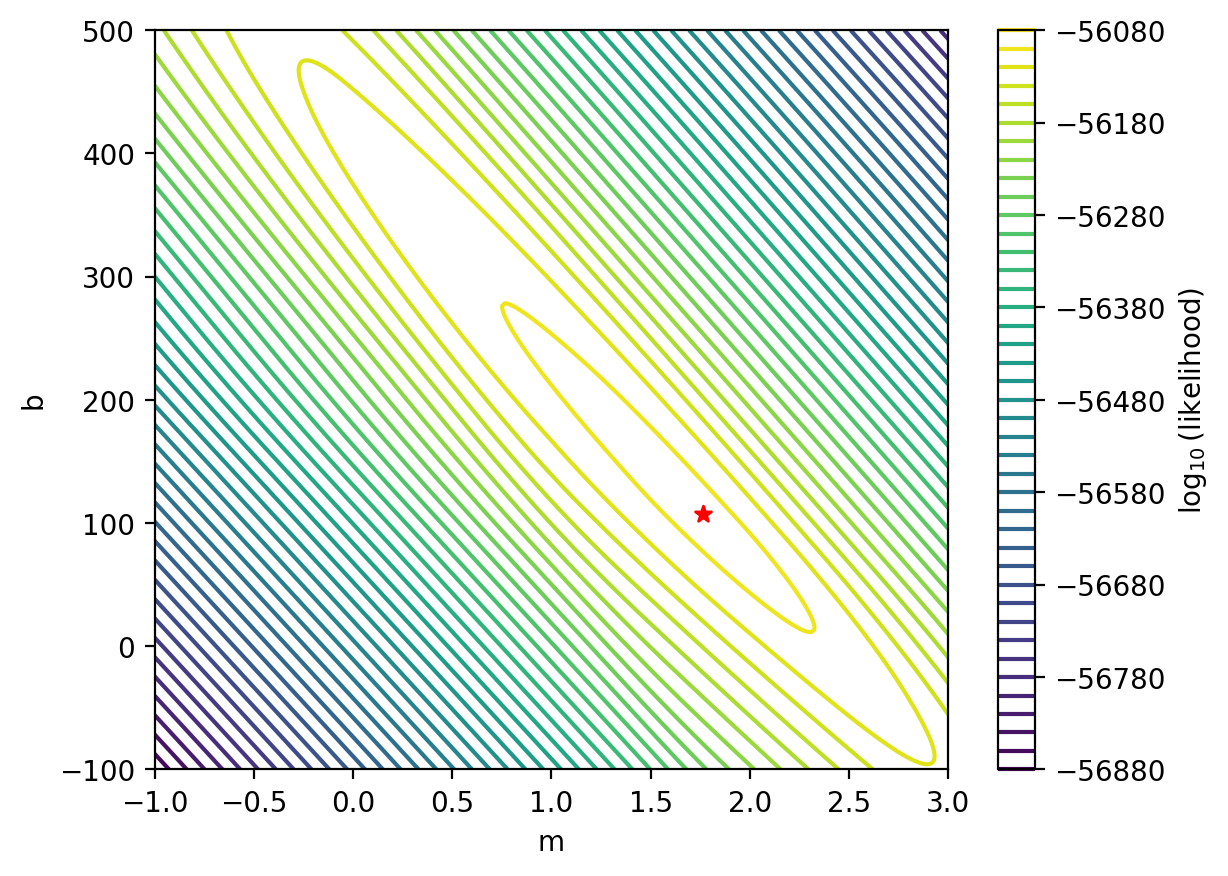

In [19]:
huber_slopes, huber_intercepts = np.mgrid[-1:3:250j, -100:500:250j]
huber_delta = 2.85
huber_log_likelihood = -0.5*(np.sum(2*np.pi*dy**2) +\
        [[summed_huber_loss((s,i),
                           huber_delta) for s in huber_slopes[:,0]] for i in huber_intercepts[0]])

plt.contour(huber_slopes[:,0], huber_intercepts[0], huber_log_likelihood,levels=50)
plt.colorbar(label=r'$\log_{10}$(likelihood)')
plt.xlabel('m')
plt.ylabel('b')

maxL_intercept_index_H, maxL_slope_index_H = np.where(huber_log_likelihood == np.max(huber_log_likelihood))
best_fit_slope_H = huber_slopes[:,0][maxL_slope_index_H[0]]
best_fit_intercept_H = huber_intercepts[0][maxL_intercept_index_H[0]]
plt.scatter(best_fit_slope_H, best_fit_intercept_H,marker='*',c='r')

Below is the fit using the Huber loss and grid search

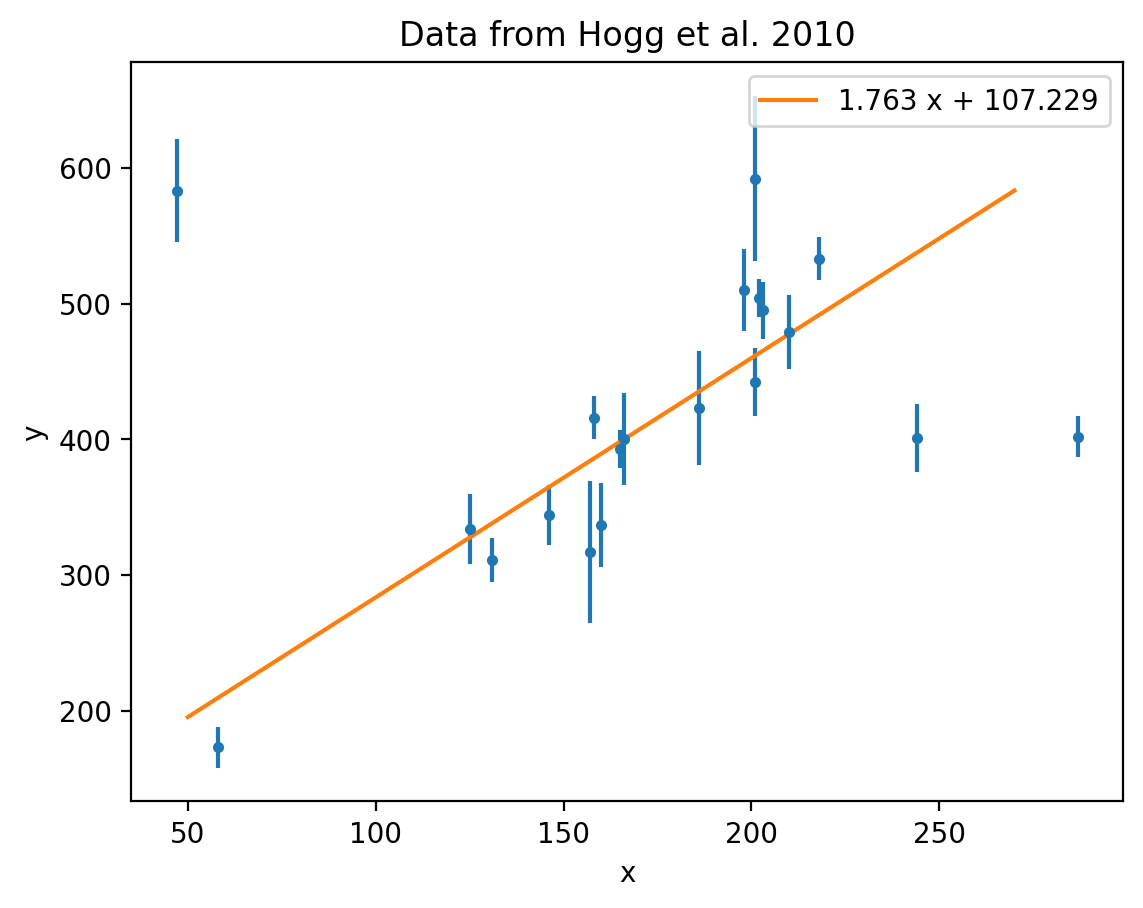

In [20]:
plt.figure()
plt.errorbar(x, y, yerr=dy, fmt='.')
x_arr = np.linspace(50, 270, 10)
plt.plot(x_arr, 
         best_fit_slope_H*x_arr + best_fit_intercept_H, 
         label='{:.3f} x + {:.3f}'.format(best_fit_slope_H, 
                                   best_fit_intercept_H))
plt.xlabel('x')
plt.ylabel('y')
plt.title('Data from Hogg et al. 2010')
plt.legend()
plt.show()

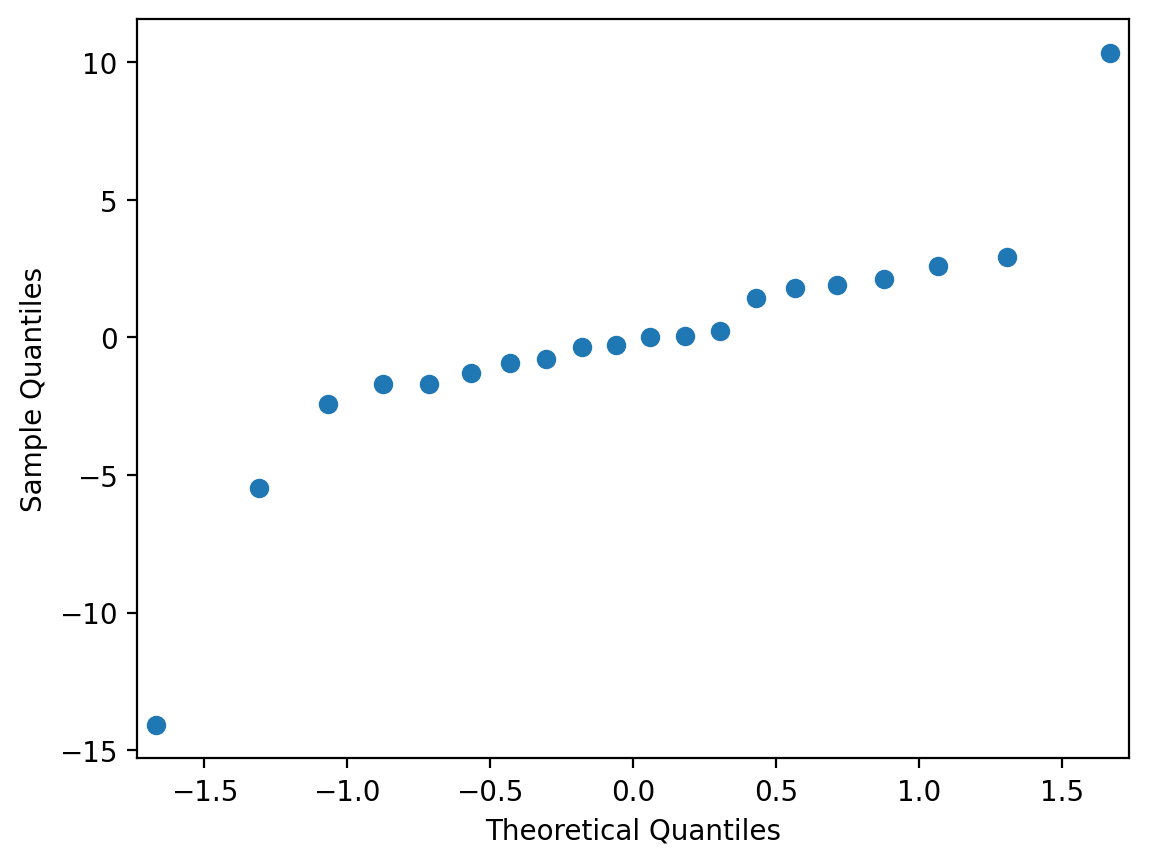

In [21]:
qqplot((y - (best_fit_slope_H*x + best_fit_intercept_H))/dy);

Above is the QQ plot for the Huber grid fit with no outlier rejection.

#### 5.) Fit a new line to all of the data (no outlier rejection) with the new Huber likelihood, except now use scipy.optimize.fmin instead of a grid search, and you know the drill by now - QQ plot of the residuals (10 pts)

In [22]:
from scipy.optimize import fmin

Using the same $\delta$, I use scipy.optimize.fmin to find the fit

In [23]:
huber_loss_for_fmin = lambda model_pair : np.sum(huber_loss(x, 
                                                           y, 
                                                           dy, 
                                                           model_pair[0], 
                                                           model_pair[1], 
                                                           2.85))

In [24]:
huber_fmin = fmin(huber_loss_for_fmin, ((best_fit_slope_H, best_fit_intercept_H)))

Optimization terminated successfully.
         Current function value: 94.744120
         Iterations: 39
         Function evaluations: 79


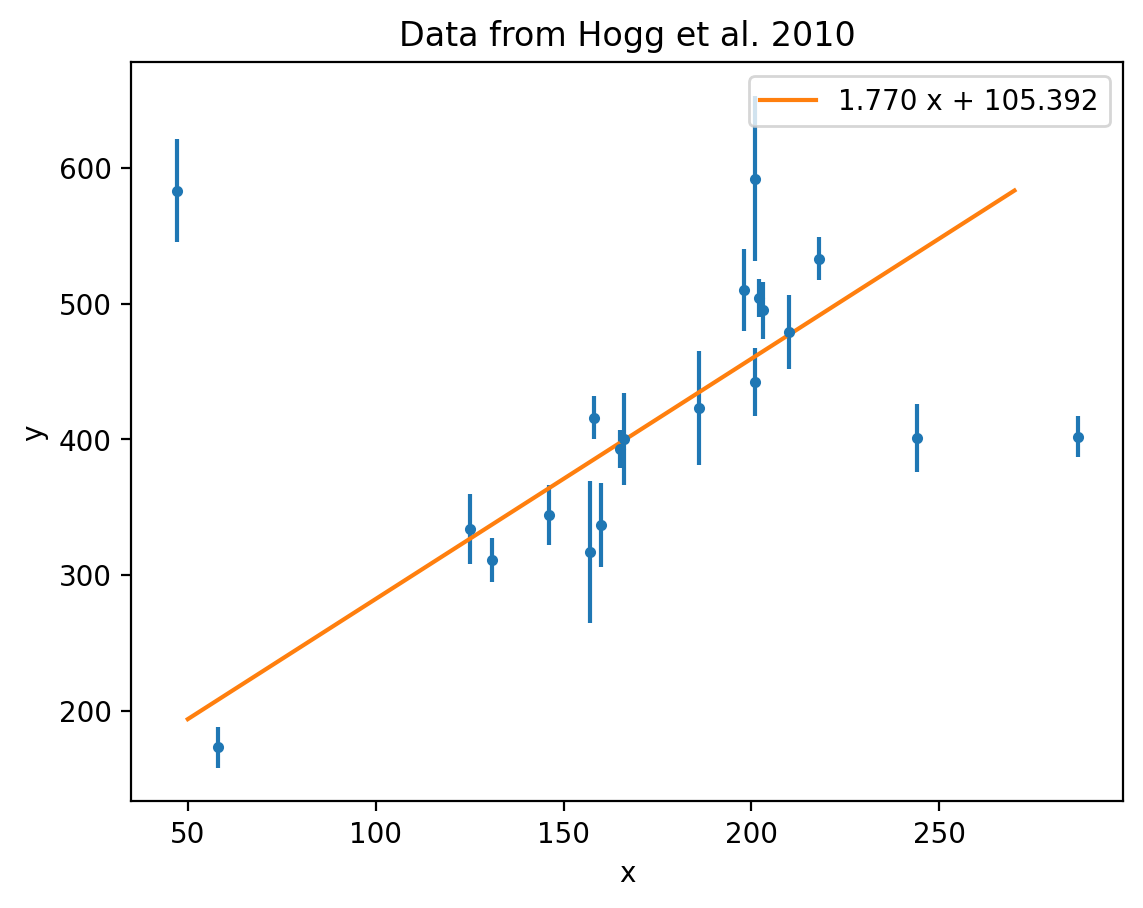

In [25]:
plt.figure()
plt.errorbar(x, y, yerr=dy, fmt='.')
x_arr = np.linspace(50, 270, 10)
plt.plot(x_arr, 
         huber_fmin[0]*x_arr + huber_fmin[1], 
         label='{:.3f} x + {:.3f}'.format(huber_fmin[0], 
                                   huber_fmin[1]))
plt.xlabel('x')
plt.ylabel('y')
plt.title('Data from Hogg et al. 2010')
plt.legend()
plt.show()

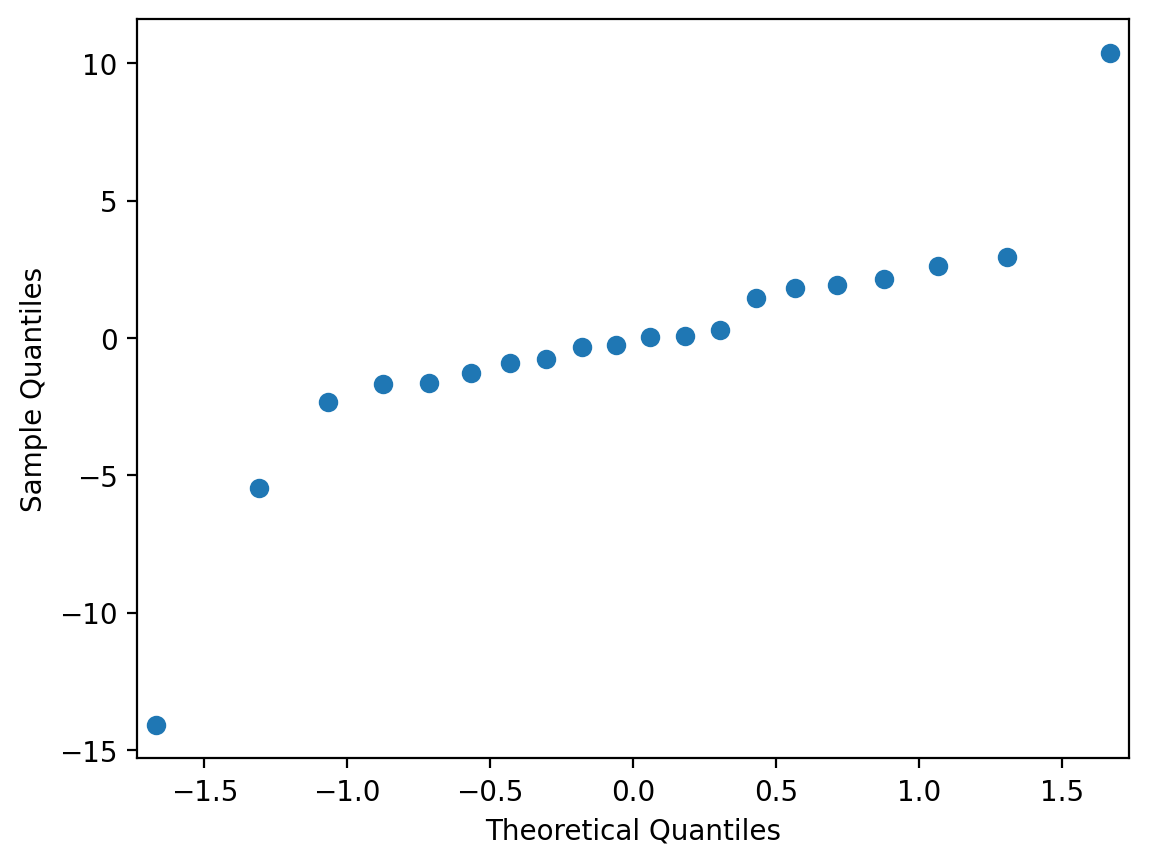

In [26]:
qqplot((y-(huber_fmin[0]*x + huber_fmin[1]))/dy);

Like with the previous Huber fit, there are fewer strong outliers than uing the L-estimator grid fit or simply minimizing squared loss without outlier rejection. Here, we only have 3 strong outliers, while the rest of the residuals sample fairly well from a normal distribution.

## Problem 2

The demo data set for this part is the Wesenheit index of the OGLE-III fundamental-mode and first overtone classical Cepheids. 

These stars are awesome because you can use them to measure distances. Here's a nice [youtube video](https://www.youtube.com/watch?v=iyisAjHdhas) on these stars.

You'll try to estimate their period-luminosity relationship. 

The Wesenheit index is defined as `W = I - 1.55(V - I)`, and its main advantage over using simply the I or V photometry is that it is insensitive to extinction. It is denoted by 'W' among the data columns. 

Other columns are 'name', the identifier of the star; 'RA0' (in decimal hours) and 'Decl0' (in decimal degrees), celestial coordinates; 'Mode', the mode of the Cepheid ('F' indicates fundamental-mode, '1' indicates first overtone star); 'Cloud', indicating which Magellanic Cloud the star belongs to; 'logP1', the base-10 logarithm of the period in days; 'VI', the colour V-I.


Split the data into LMC and SMC, and then again by mode F and 1, and plot the `W` on the y-axis vs `log(P1)` on x.
Fit or estimate straight lines to each of the four samples using your solution to Problem 1. (10 pts)

Compute the residuals of each sample to it's respective line. Do these residuals look like a normal distribution? If not, speculate on why (WATCH THE YOUTUBE VIDEO!) (10 pts)

Plot the residuals color coded by if they are positive or negative vs RA and Dec (just like a Hess diagram in Problem 1). (15 pts)

Finally, plot the residuals against the fitted `W` values, and just to anticipate the next homework assignment, also plot `log(P1) vs V-I`. Comment on what you are seeing. (15 pts)

In [27]:
import pandas as pd
from astropy.stats import knuth_bin_width

In [28]:
# Read the csv file
cepheids = pd.read_csv('Cepheids.csv')

In [29]:
# Inspect the csv file
cepheids

name       RA0      Decl0 Mode Cloud         W     logP1  \
0     OGLE-LMC-CEP-0002  4.529733 -69.819330    F   LMC  14.52500  0.493893   
1     OGLE-LMC-CEP-0005  4.592089 -69.734970    F   LMC  13.49540  0.749122   
2     OGLE-LMC-CEP-0012  4.630203 -67.214420    F   LMC  14.54210  0.424912   
3     OGLE-LMC-CEP-0016  4.642367 -67.646310    F   LMC  12.03300  1.021456   
4     OGLE-LMC-CEP-0017  4.649119 -69.688390    F   LMC  14.34215  0.565524   
...                 ...       ...        ...  ...   ...       ...       ...   
7264  OGLE-SMC-CEP-4622  1.404808 -73.269361    1   SMC  15.94460  0.141140   
7265  OGLE-SMC-CEP-4624  1.406767 -74.192639    1   SMC  15.29565  0.102449   
7266  OGLE-SMC-CEP-4625  1.407181 -72.936056    1   SMC  15.33725  0.074740   
7267  OGLE-SMC-CEP-4627  1.413575 -72.599167    1   SMC  14.06670  0.501477   
7268  OGLE-SMC-CEP-4628  1.419358 -73.926583    1   SMC  16.53315 -0.438446   

         VI  
0     0.740  
1     0.752  
2     0.598  
3     1.080  
4     0.647  
...     ...  
7264  0.648  
7265  0.577  
7266  0.485  
7267  0.686  
7268  0.767  

[7269 rows x 8 columns]

#### Split the data into LMC and SMC, and then again by mode F and 1, and plot the W on the y-axis vs log(P1) on x. Fit or estimate straight lines to each of the four samples using your solution to Problem 1. (10 pts)

First, let's take a look at the four scatter plots:

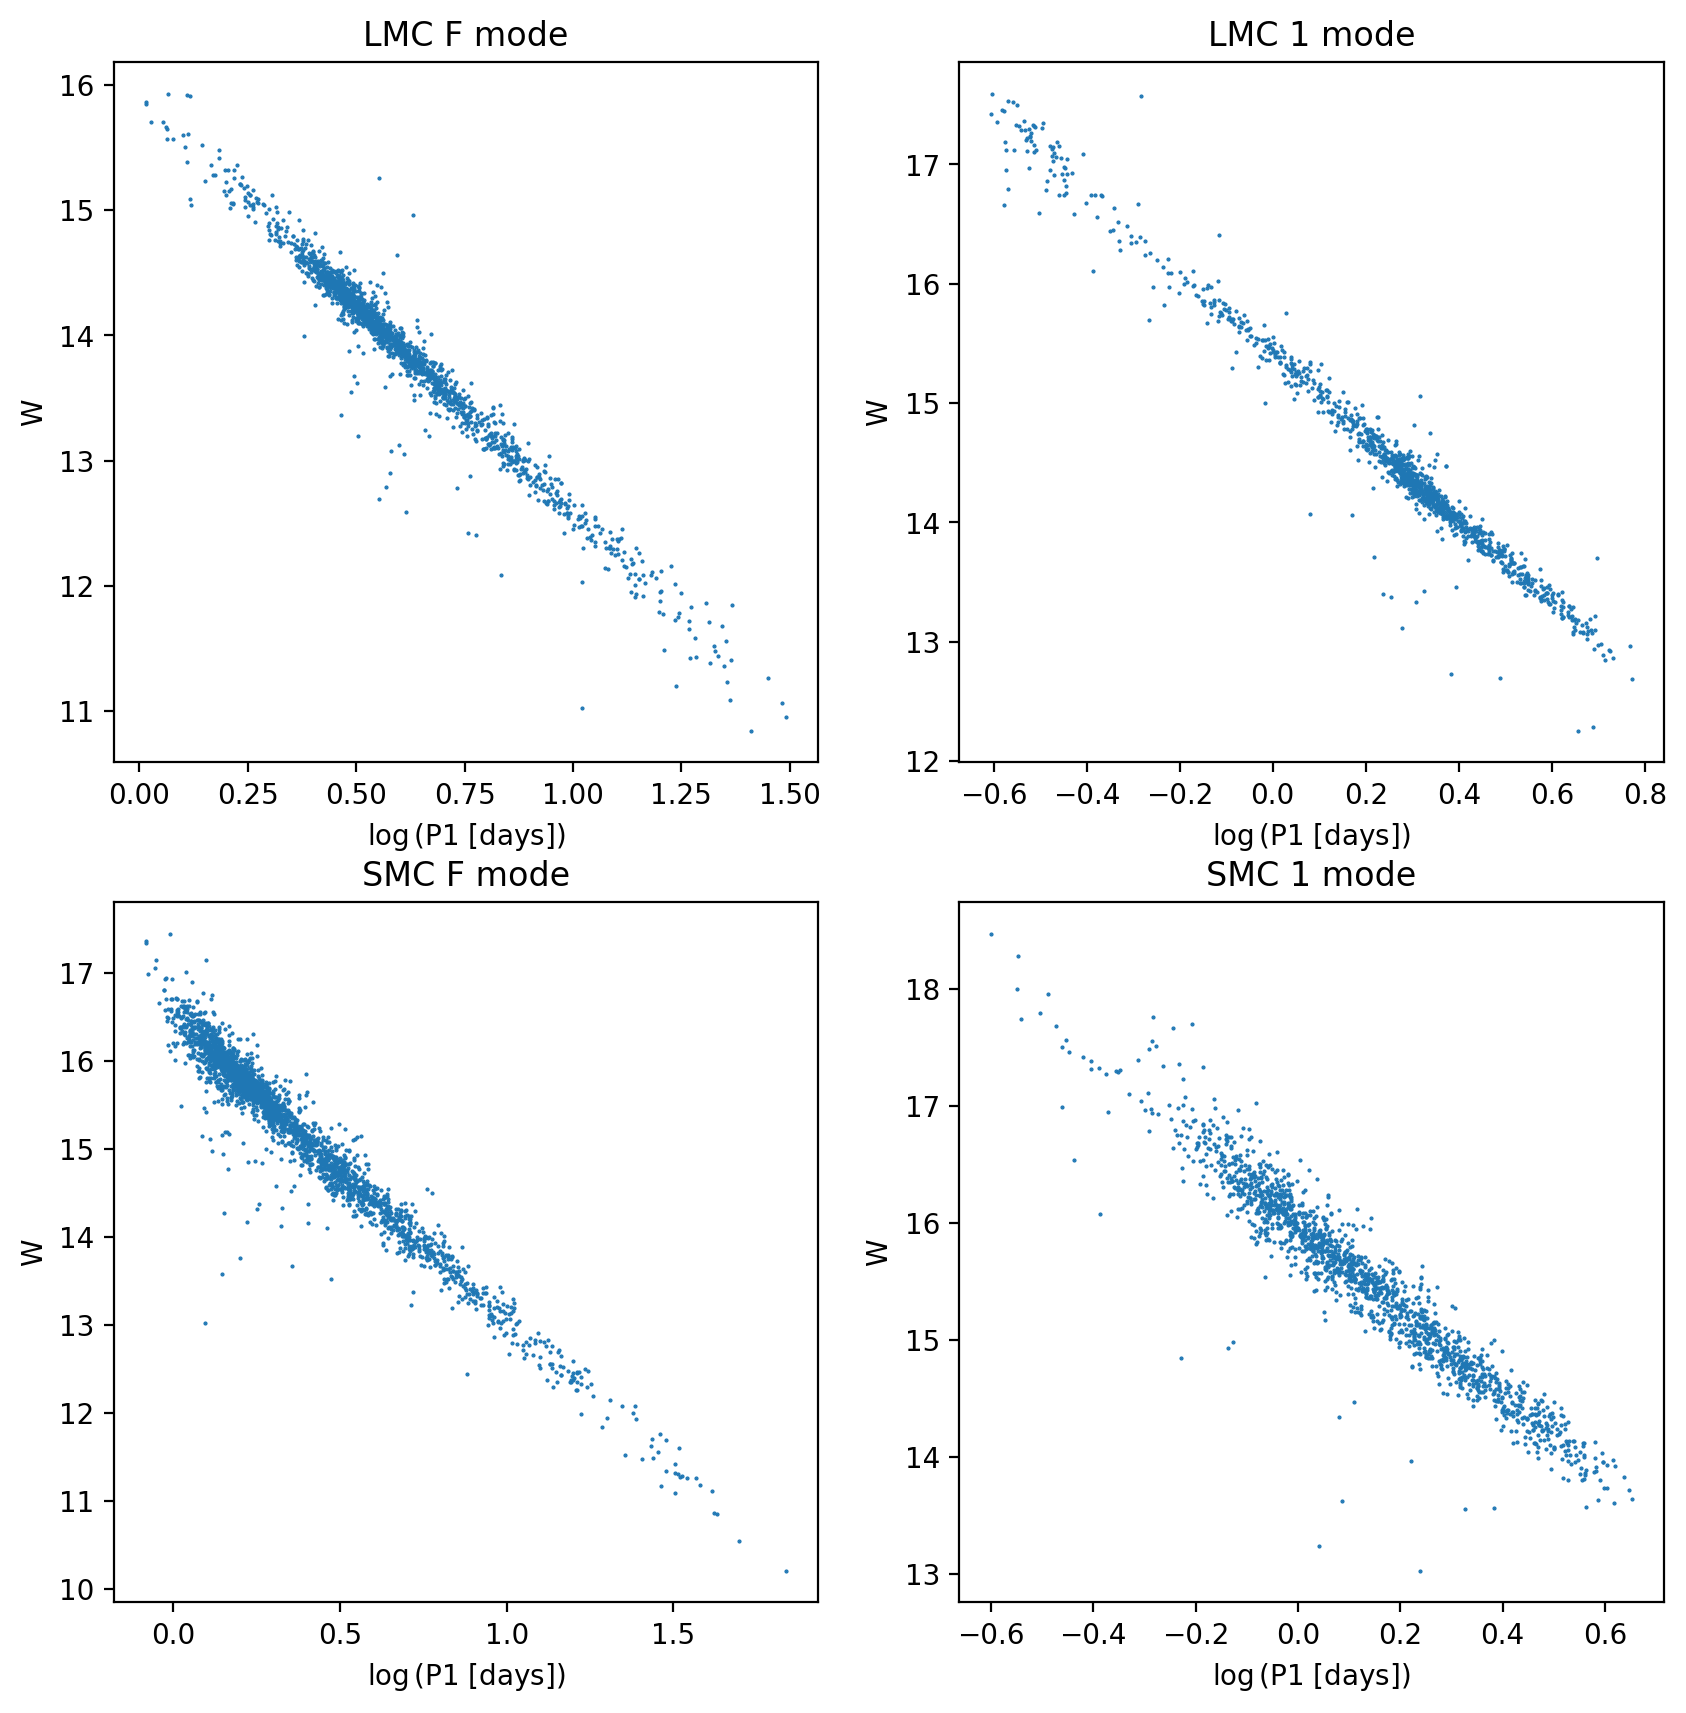

In [30]:
plt.figure(figsize=(10,10),dpi=100)
subplot_count = 1
for cloud in ['LMC', 'SMC']:
    for mode in ['F', '1']:
        plt.subplot(2,2,subplot_count)
        mask = (cepheids['Cloud'] == cloud) & (cepheids['Mode'] == mode)
        plt.scatter(cepheids['logP1'][mask], cepheids['W'][mask],marker='.',s=1)
        plt.title('{} {} mode'.format(cloud, mode))
        plt.xlabel(r'$\log$(P1 [days])')
        plt.ylabel('W')
        subplot_count += 1

We should reasonablly expect all four subsets to have negative slopes and positive intercepts. Let's take some 0th order guesses to the fits to have some reasonable grid/first guess to start the fit. 


| Data set    | m_guess     | b_guess     |
| ----------- | ----------- | ----------- |
| LMC F       | -3.3        | 15.8        |
| LMC 1       | -3.8        | 15.5        |
| SMC F       | -3.5        | 16.5        |
| SMC 1       | -5.3        | 16.0        |

Next, let's look at the histograms of residuals from these 0th order guesses to get a sensible $\delta$ for the Huber loss function

LMC F 90-10 IQR = 0.21673954979495047
LMC F 75-25 IQR = 0.0986780345697138
LMC 1 90-10 IQR = 0.3267789778335549
LMC 1 75-25 IQR = 0.13502727827832794
SMC F 90-10 IQR = 0.41104595887160617
SMC F 75-25 IQR = 0.18281327849494744
SMC 1 90-10 IQR = 1.020318649125622
SMC 1 75-25 IQR = 0.5326192548268724


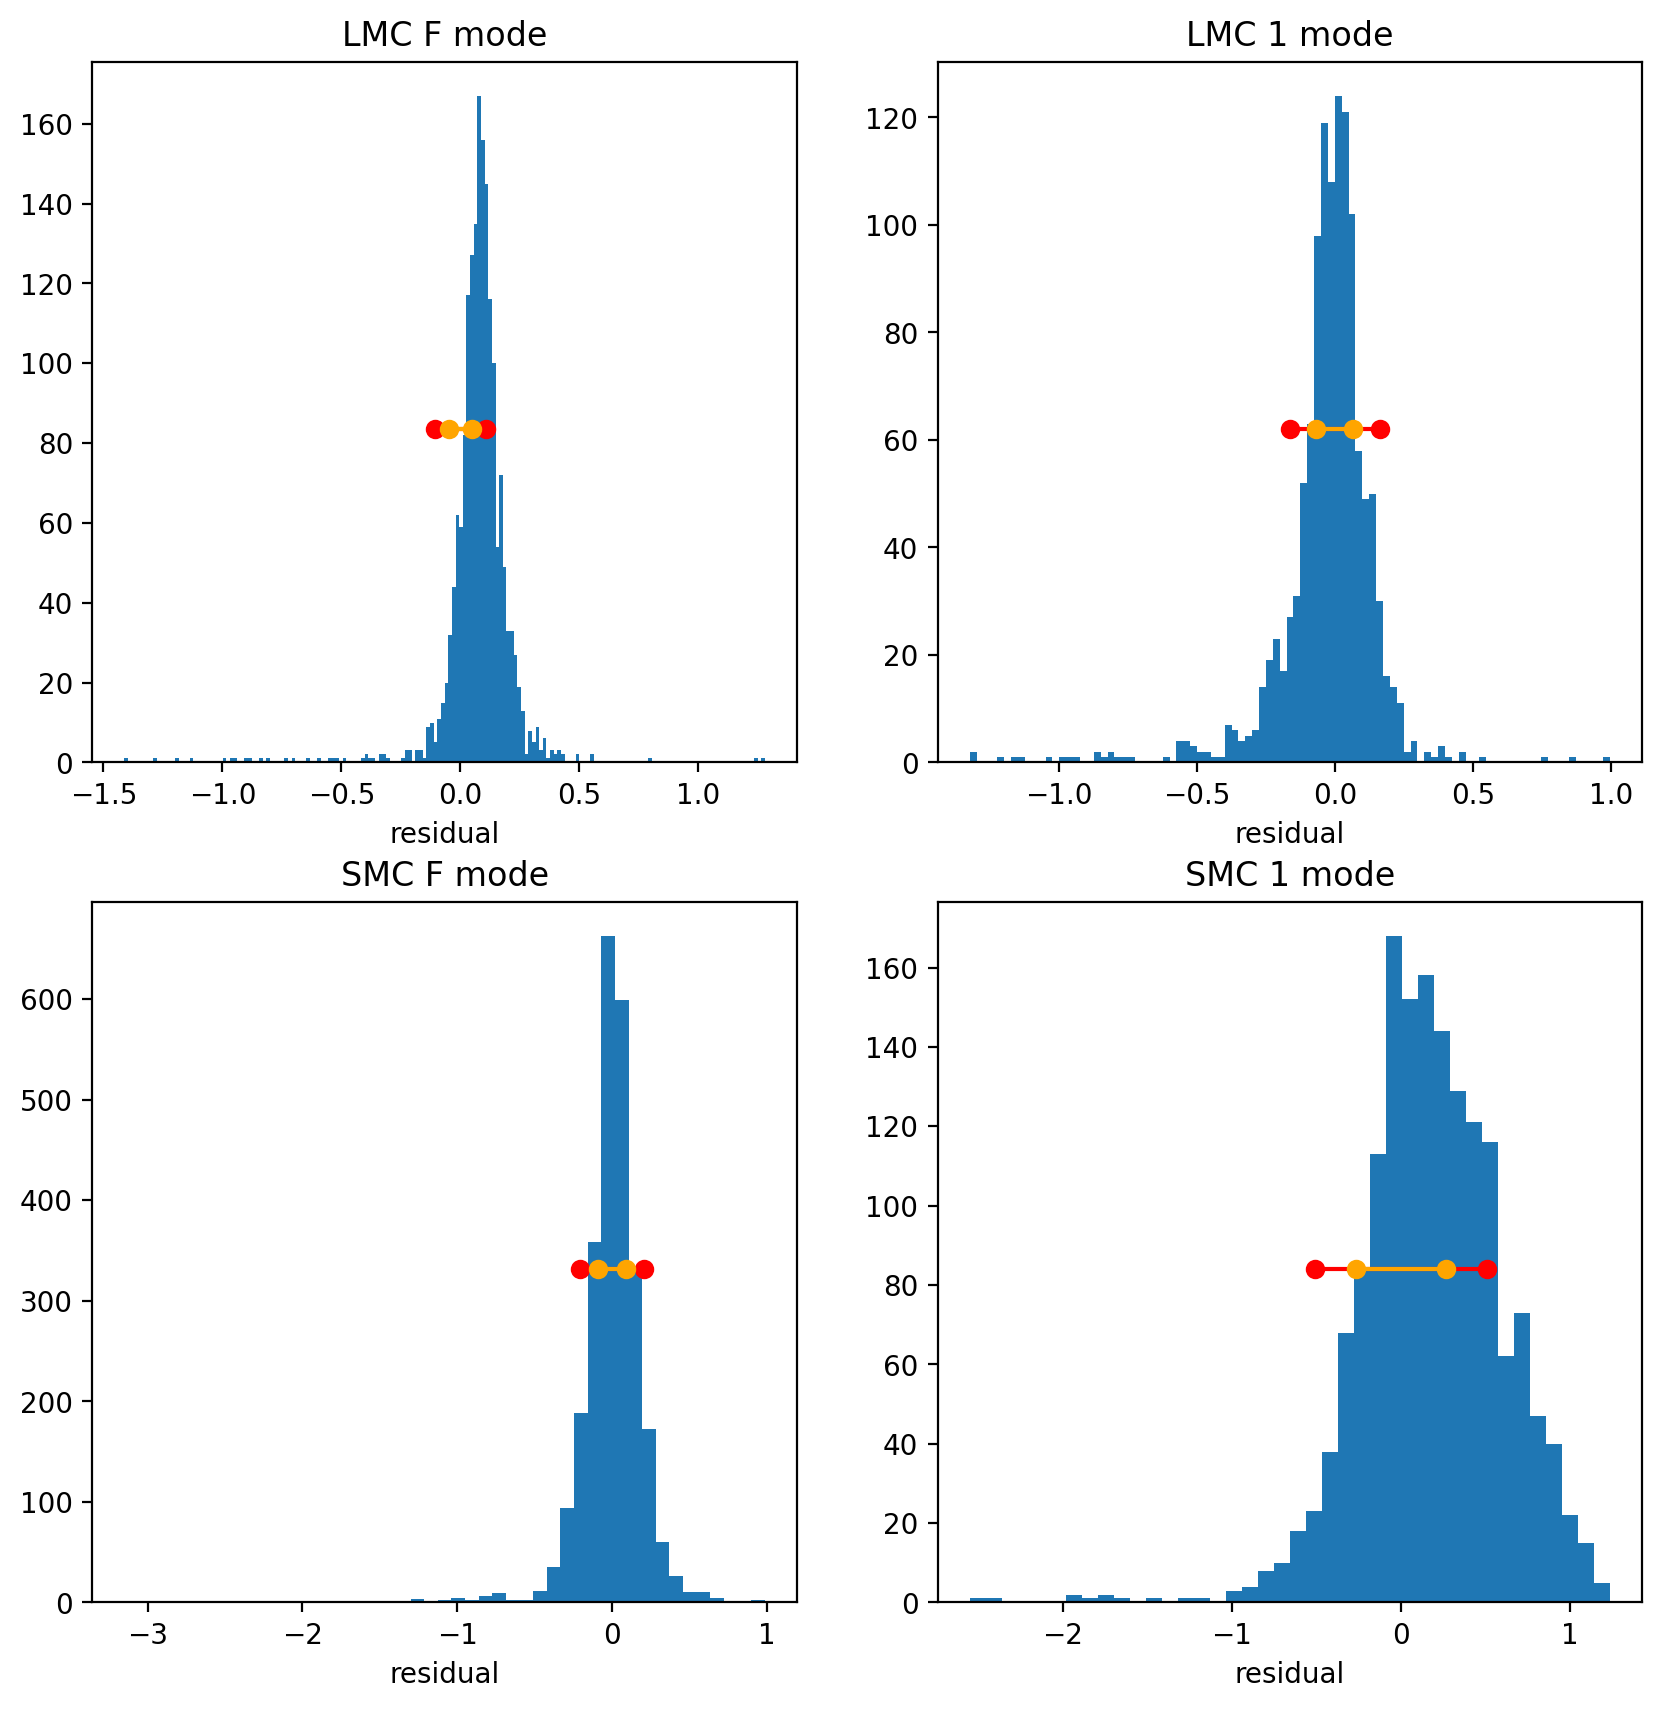

In [31]:
fit_param_guesses = [(-3.3, 15.8),(-3.8, 15.5),(-3.5,16.5),(-5.3, 16.0)]
plt.figure(figsize=(10,10),dpi=100)
subplot_count = 1
for cloud in ['LMC', 'SMC']:
    for mode in ['F', '1']:
        plt.subplot(2,2,subplot_count)
        mask = (cepheids['Cloud'] == cloud) & (cepheids['Mode'] == mode)
        m, b = fit_param_guesses[subplot_count-1]
        resid = cepheids['W'][mask] - (m*cepheids['logP1'][mask] + b)
        n_bins = int(np.round((np.max(resid)-np.min(resid))/knuth_bin_width(resid)))
        h = plt.hist(resid, bins=n_bins)
        half_max = np.max(h[0])/2
        plt.title('{} {} mode'.format(cloud, mode))
        plt.xlabel(r'residual')
        iqr = np.percentile(resid, 90) - np.percentile(resid, 10)
        print('{} {} 90-10 IQR = {}'.format(cloud, mode, iqr))
        plt.plot([-iqr/2, iqr/2], [half_max,half_max],'o-',c='r')
        iqr = np.percentile(resid, 75) - np.percentile(resid, 25)
        plt.plot([-iqr/2, iqr/2], [half_max,half_max],'o-',c='orange')
        print('{} {} 75-25 IQR = {}'.format(cloud, mode, iqr))
        subplot_count += 1

Like in Problem 1, the red (orange) ranges show the 90\%-10\% (75\%-25\%) IQR. Again, the 90-10 IQR is pretty good at characterizing the distribution of residuals while excluding outliers. Since we want $\delta$ to be half of the IQR, we'll use the following $\delta$s:


| Data set    | $\delta$     | 
| ----------- | ----------- |
| LMC F       | 0.108       |
| LMC 1       | 0.163       |
| SMC F       | 0.206       |
| SMC 1       | 0.510       |

Since we don't have uncertainties on our measurements of W or log(P1), we'll have to define a new function, but otherwise the procedure should be the same as in Problem 1.

Optimization terminated successfully.
         Current function value: 8.499046
         Iterations: 32
         Function evaluations: 64
Optimization terminated successfully.
         Current function value: 7.536312
         Iterations: 34
         Function evaluations: 67
Optimization terminated successfully.
         Current function value: 36.795865
         Iterations: 29
         Function evaluations: 57
Optimization terminated successfully.
         Current function value: 33.408912
         Iterations: 45
         Function evaluations: 86


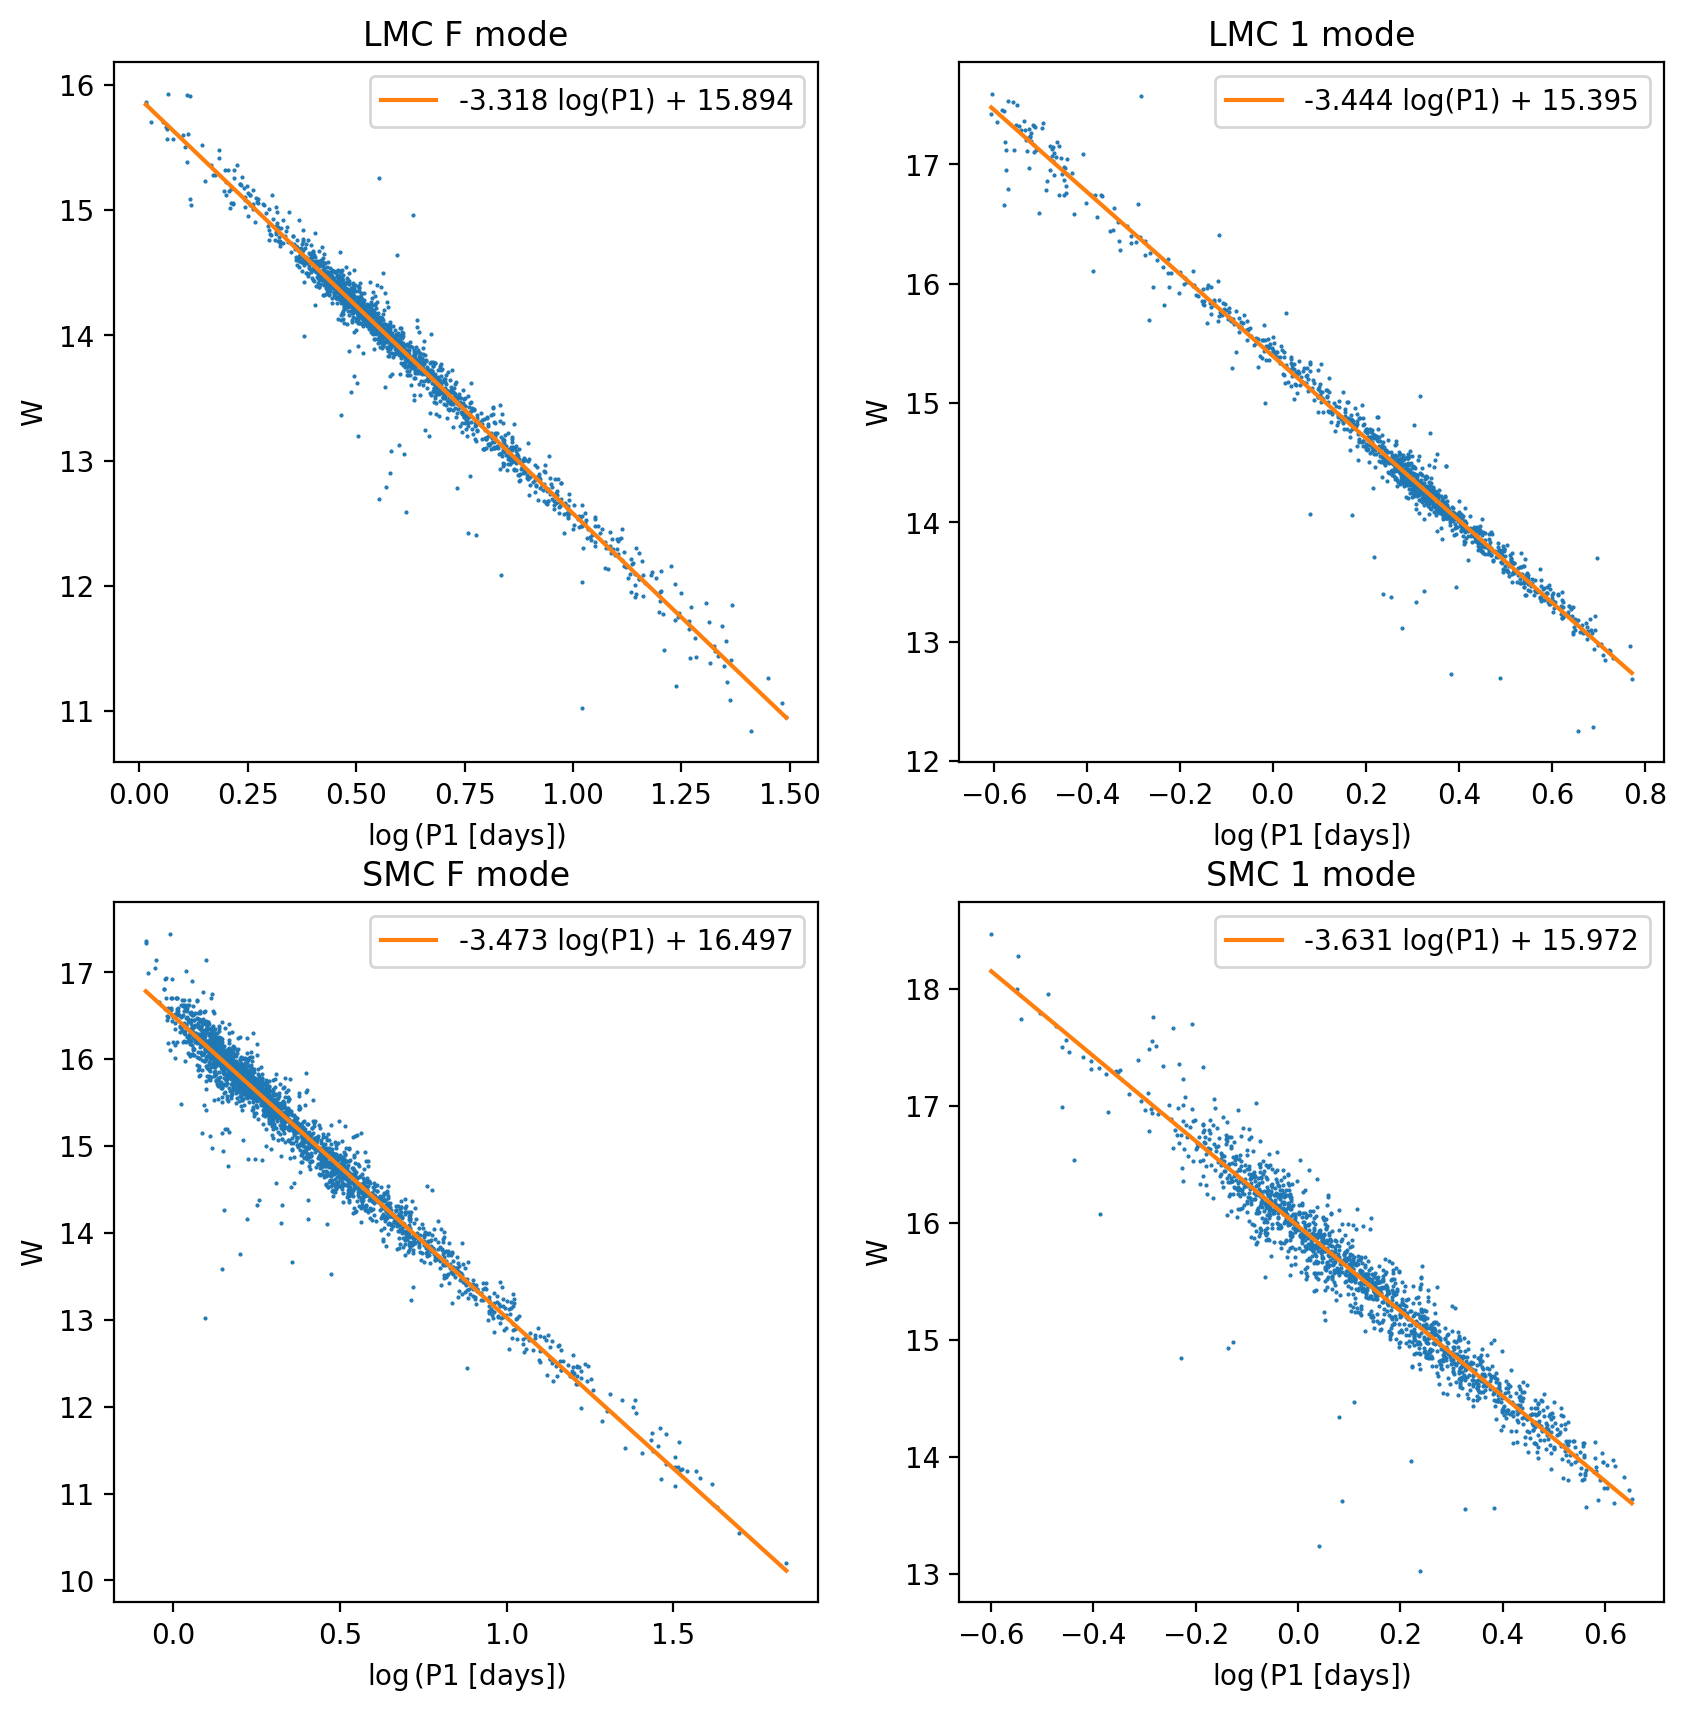

In [32]:
huber_deltas = [0.108, 0.163, 0.206, 0.510]
def huber_loss_no_uncertainties(x, y, m, b, delta):
    residual = (y - (m*x + b))
    loss = np.ones_like(residual)
    condition = abs(residual) <= delta
    loss[condition] = 0.5*(residual[condition])**2
    loss[~condition] = delta*(abs(residual[~condition]) - 0.5*delta)
    return loss

huber_param_out = [(0,0), (0,0), (0,0), (0,0)]

plt.figure(figsize=(10,10),dpi=100)
subplot_count = 1
for cloud in ['LMC', 'SMC']:
    for mode in ['F', '1']:
        plt.subplot(2,2,subplot_count)
        mask = (cepheids['Cloud'] == cloud) & (cepheids['Mode'] == mode)

        huber_loss_for_fmin = lambda model_pair : np.sum(huber_loss_no_uncertainties(cepheids['logP1'][mask], 
                                                           cepheids['W'][mask], 
                                                           model_pair[0], 
                                                           model_pair[1], 
                                                           huber_deltas[subplot_count - 1]))
        
        huber_fmin = fmin(huber_loss_for_fmin, fit_param_guesses[subplot_count - 1])
        huber_param_out[subplot_count - 1] = huber_fmin
        plt.scatter(cepheids['logP1'][mask], cepheids['W'][mask],marker='.',s=1)
        plt.title('{} {} mode'.format(cloud, mode))
        plt.xlabel(r'$\log$(P1 [days])')
        plt.ylabel('W')
        
        x_arr = np.linspace(np.min(cepheids['logP1'][mask]), np.max(cepheids['logP1'][mask]), 10)
        
        plt.plot(x_arr, huber_fmin[0]*x_arr + huber_fmin[1], 
                 label='{:.3f} log(P1) + {:.3f}'.format(huber_fmin[0], huber_fmin[1]),
                color='tab:orange')
        plt.legend()

        subplot_count += 1



In [33]:
huber_param_out

[array([-3.31762034, 15.8942563 ]),
 array([-3.44355148, 15.3946354 ]),
 array([-3.47266201, 16.49747718]),
 array([-3.63100704, 15.97161413])]

The fits using Huber loss and scipy.optimize.fmin

| Data set    | m     | b     |
| ----------- | ----------- | ----------- |
| LMC F       | -3.318        | 15.894        |
| LMC 1       | -3.444        | 15.395        |
| SMC F       | -3.473        | 16.497        |
| SMC 1       | -3.631        | 15.972        |

#### Compute the residuals of each sample to its respective line. Do these residuals look like a normal distribution? If not, speculate on why (WATCH THE YOUTUBE VIDEO!) (10 pts)

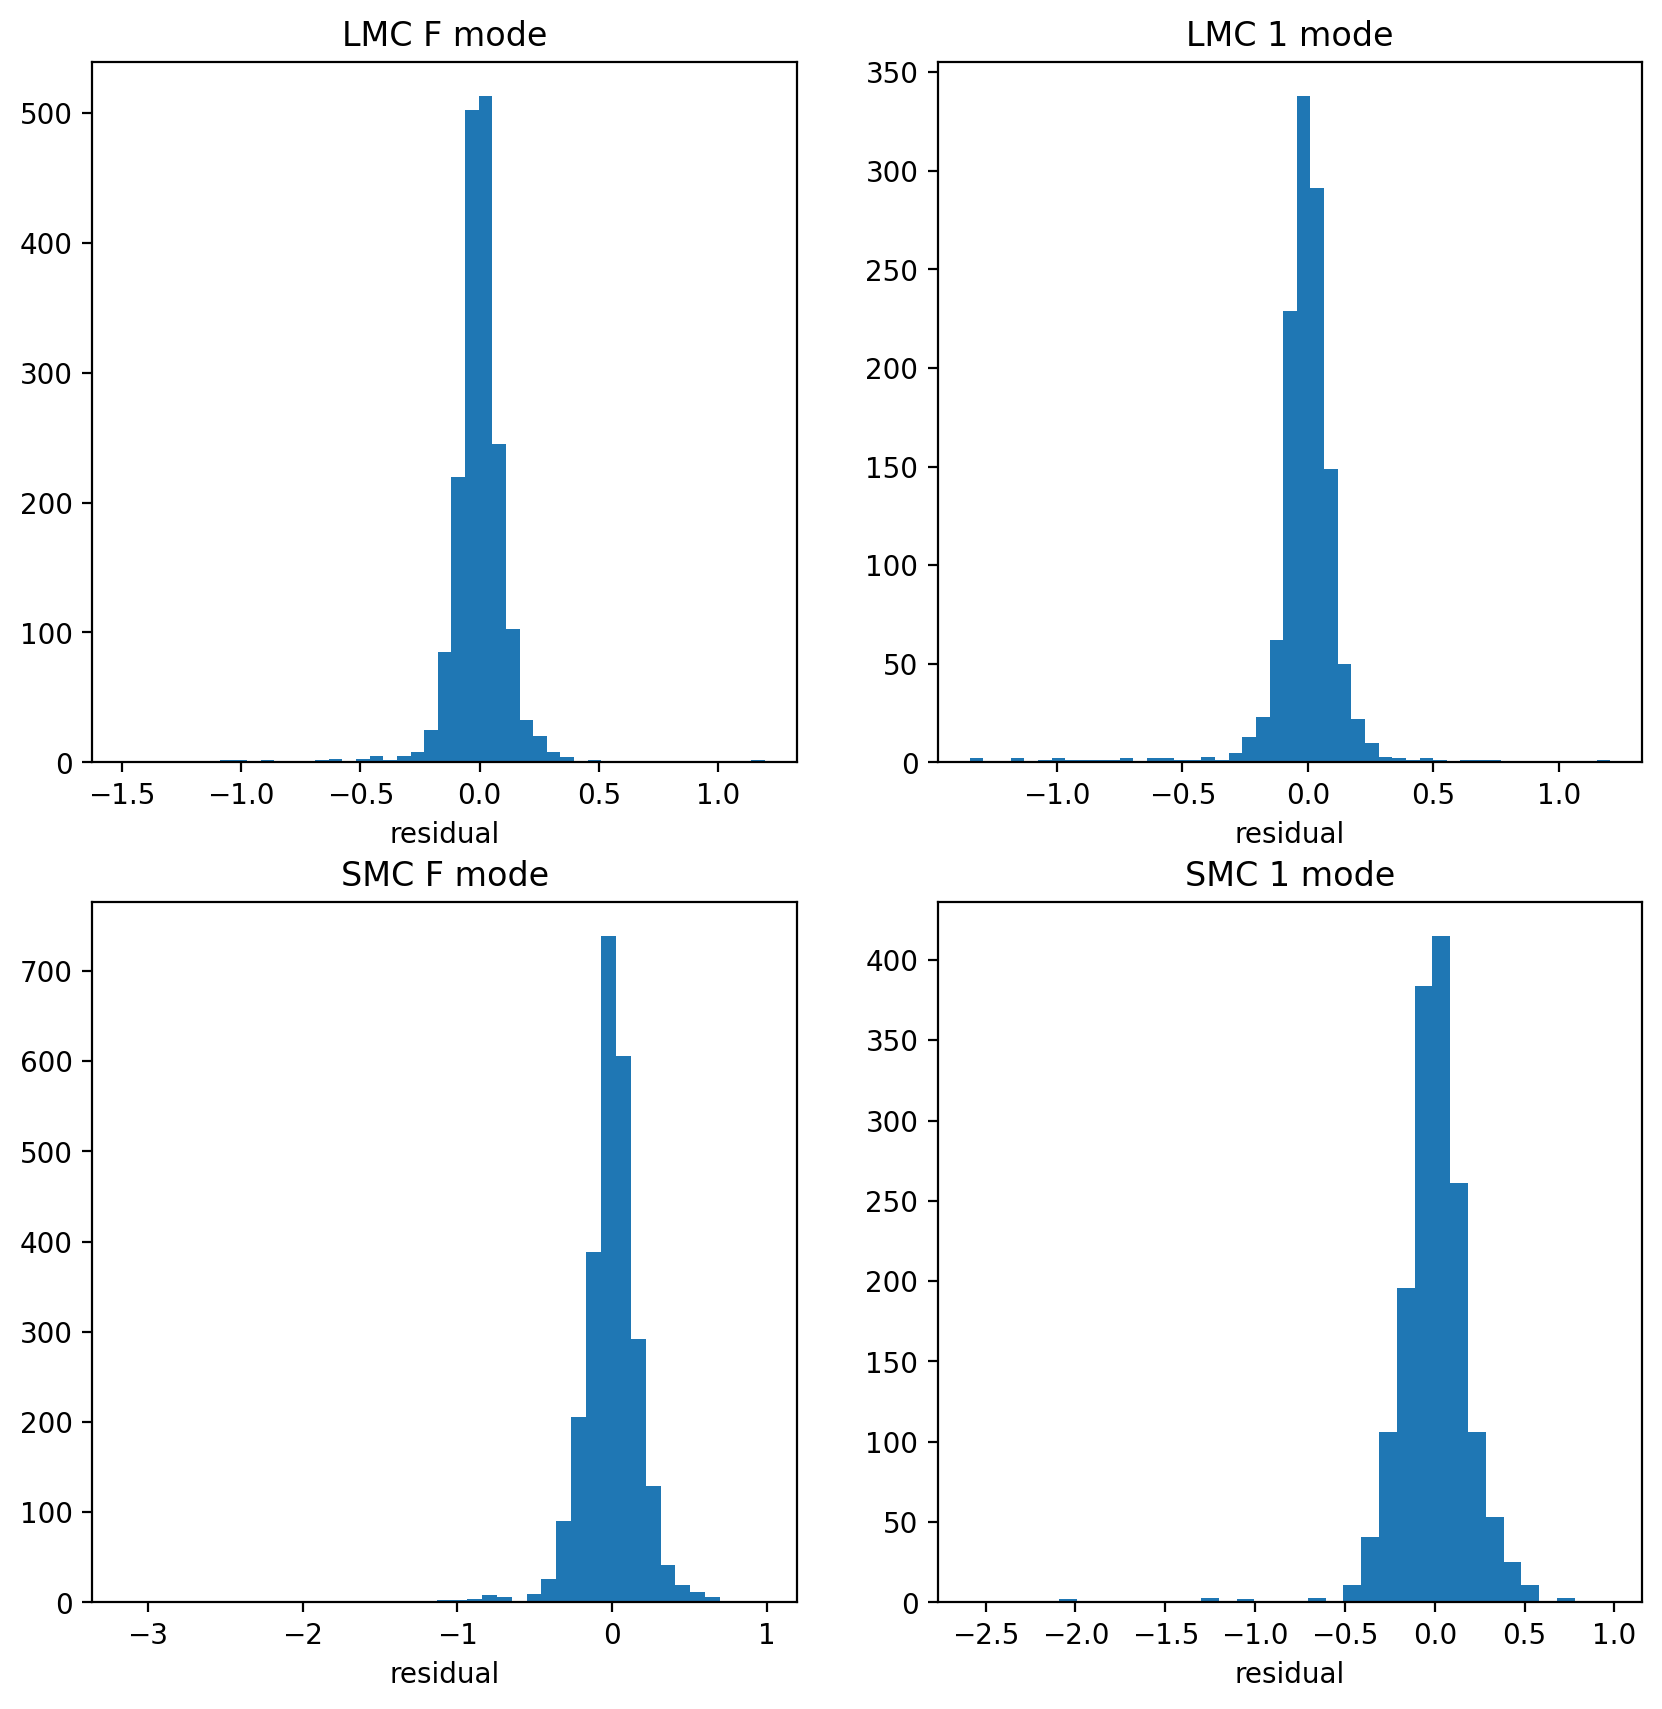

In [34]:
plt.figure(figsize=(10,10),dpi=100)
subplot_count = 1
for cloud in ['LMC', 'SMC']:
    for mode in ['F', '1']:
        plt.subplot(2,2,subplot_count)
        mask = (cepheids['Cloud'] == cloud) & (cepheids['Mode'] == mode)
        resids = cepheids['W'][mask] -\
            (huber_param_out[subplot_count-1][0]*cepheids['logP1'][mask] + huber_param_out[subplot_count-1][1])
        bin_width = knuth_bin_width(resids)
        n_bins = np.round((resids.max()-resids.min())/bin_width).astype(int)
        plt.hist(resids,bins=n_bins)
        plt.title('{} {} mode'.format(cloud, mode))
        plt.xlabel('residual')
        
        subplot_count += 1
plt.show()    

These look a bit narrow to be Gaussian, but lets check the QQ plots to get another view of the distribution of residuals:

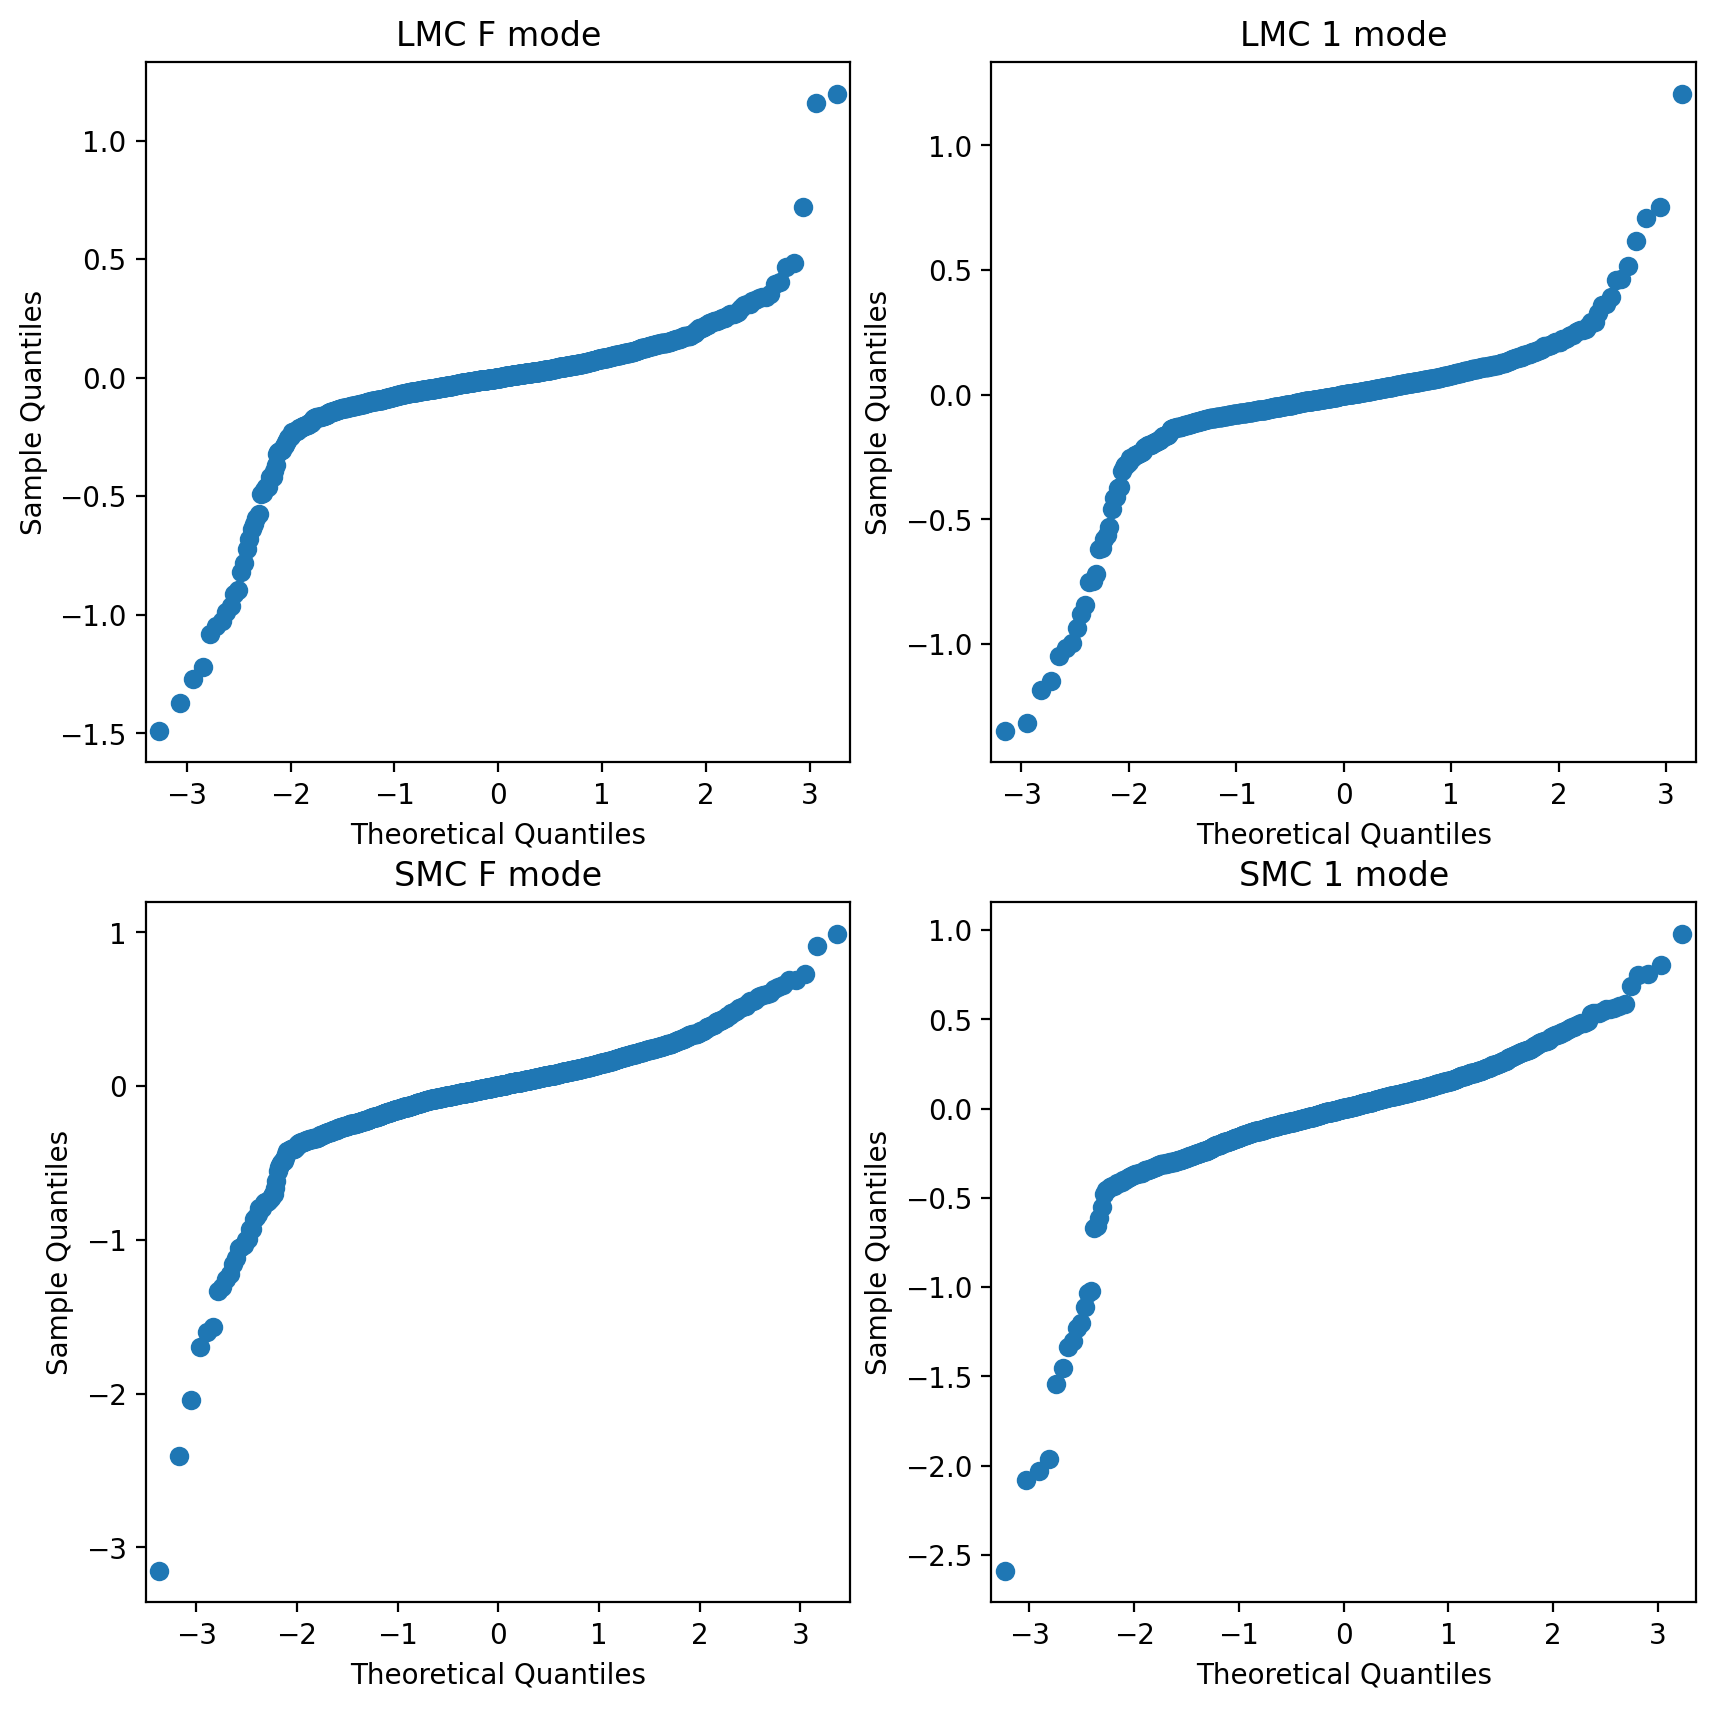

In [35]:
plt.figure(figsize=(10,10))
subplot_count = 1
for cloud in ['LMC', 'SMC']:
    for mode in ['F', '1']:
        mask = (cepheids['Cloud'] == cloud) & (cepheids['Mode'] == mode)
        resids = cepheids['W'][mask] -\
            (huber_param_out[subplot_count-1][0]*cepheids['logP1'][mask] + huber_param_out[subplot_count-1][1])
        ax = plt.subplot(2,2,subplot_count)
        sm.qqplot(resids,ax=ax); #,line='45'
        plt.title('{} {} mode'.format(cloud, mode))
        subplot_count += 1

In [36]:
(10**1.5)

31.622776601683793

These look a lot more like Cauchy distributions than normal distributions. If the distribution doens't seem like it came from a normal distribution, then we should look at what's baked in when we assume a measurement can be well characterized by a normal distribution.

First, we should note that these measurements do not have associated uncertainties. It's fine that we do not have uncertainties on period--after enough measurements of the full phase of the Cepheid, you can get a precise measurement of period. We're not really limited by uncertainties in time either, integration periods for these sorts of measurements are very short compared to the $\sim$ 6 hour to 30 day periods that these Cepheids span. However, magnitude measurements are uncertain to some non-negligible degree, even with really good instrumentation, and especially for large magnitude (low flux) stars. In our fits, the data are equally weighted, but I would expect that lower magnitude data should be more heavily weighted, which would change the fits, although it's not immediately clear from visual inspection that this would make the distribution of residuals more Gaussian.

In expecting a normal distribution of residuals, we're really saying that we expect our data to be independent and identically distributed. It's a fair assumption to think that the data are independent: we would not expect Cepheid periods or luminosities to be coupled, it would be very challenging to think of a physical model that could explain why they should be. However, it is probably not true that Cepheids are identically distributed in period-magnitude space. We don't find classical Cepheids below a given flux for want of trying, but rather because Cepheids only exist on the instability strip of the HR diagram. Likewise, Cepheid periods are limited in the range of several hours to several days. The fits we make shouldn't be extrapolated out of the range of our data because in general, Cepheids do not exist there! 

The Wesenheit index was chosen because it is insensitive to extinction. This is a good choice: if dust extinction were significant along the line of sight, there would be huge systematic errors in these measurements that were not accounted for.

#### Plot the residuals color coded by if they are positive or negative vs RA and Dec (just like a Hess diagram in Problem 1). (15 pts)

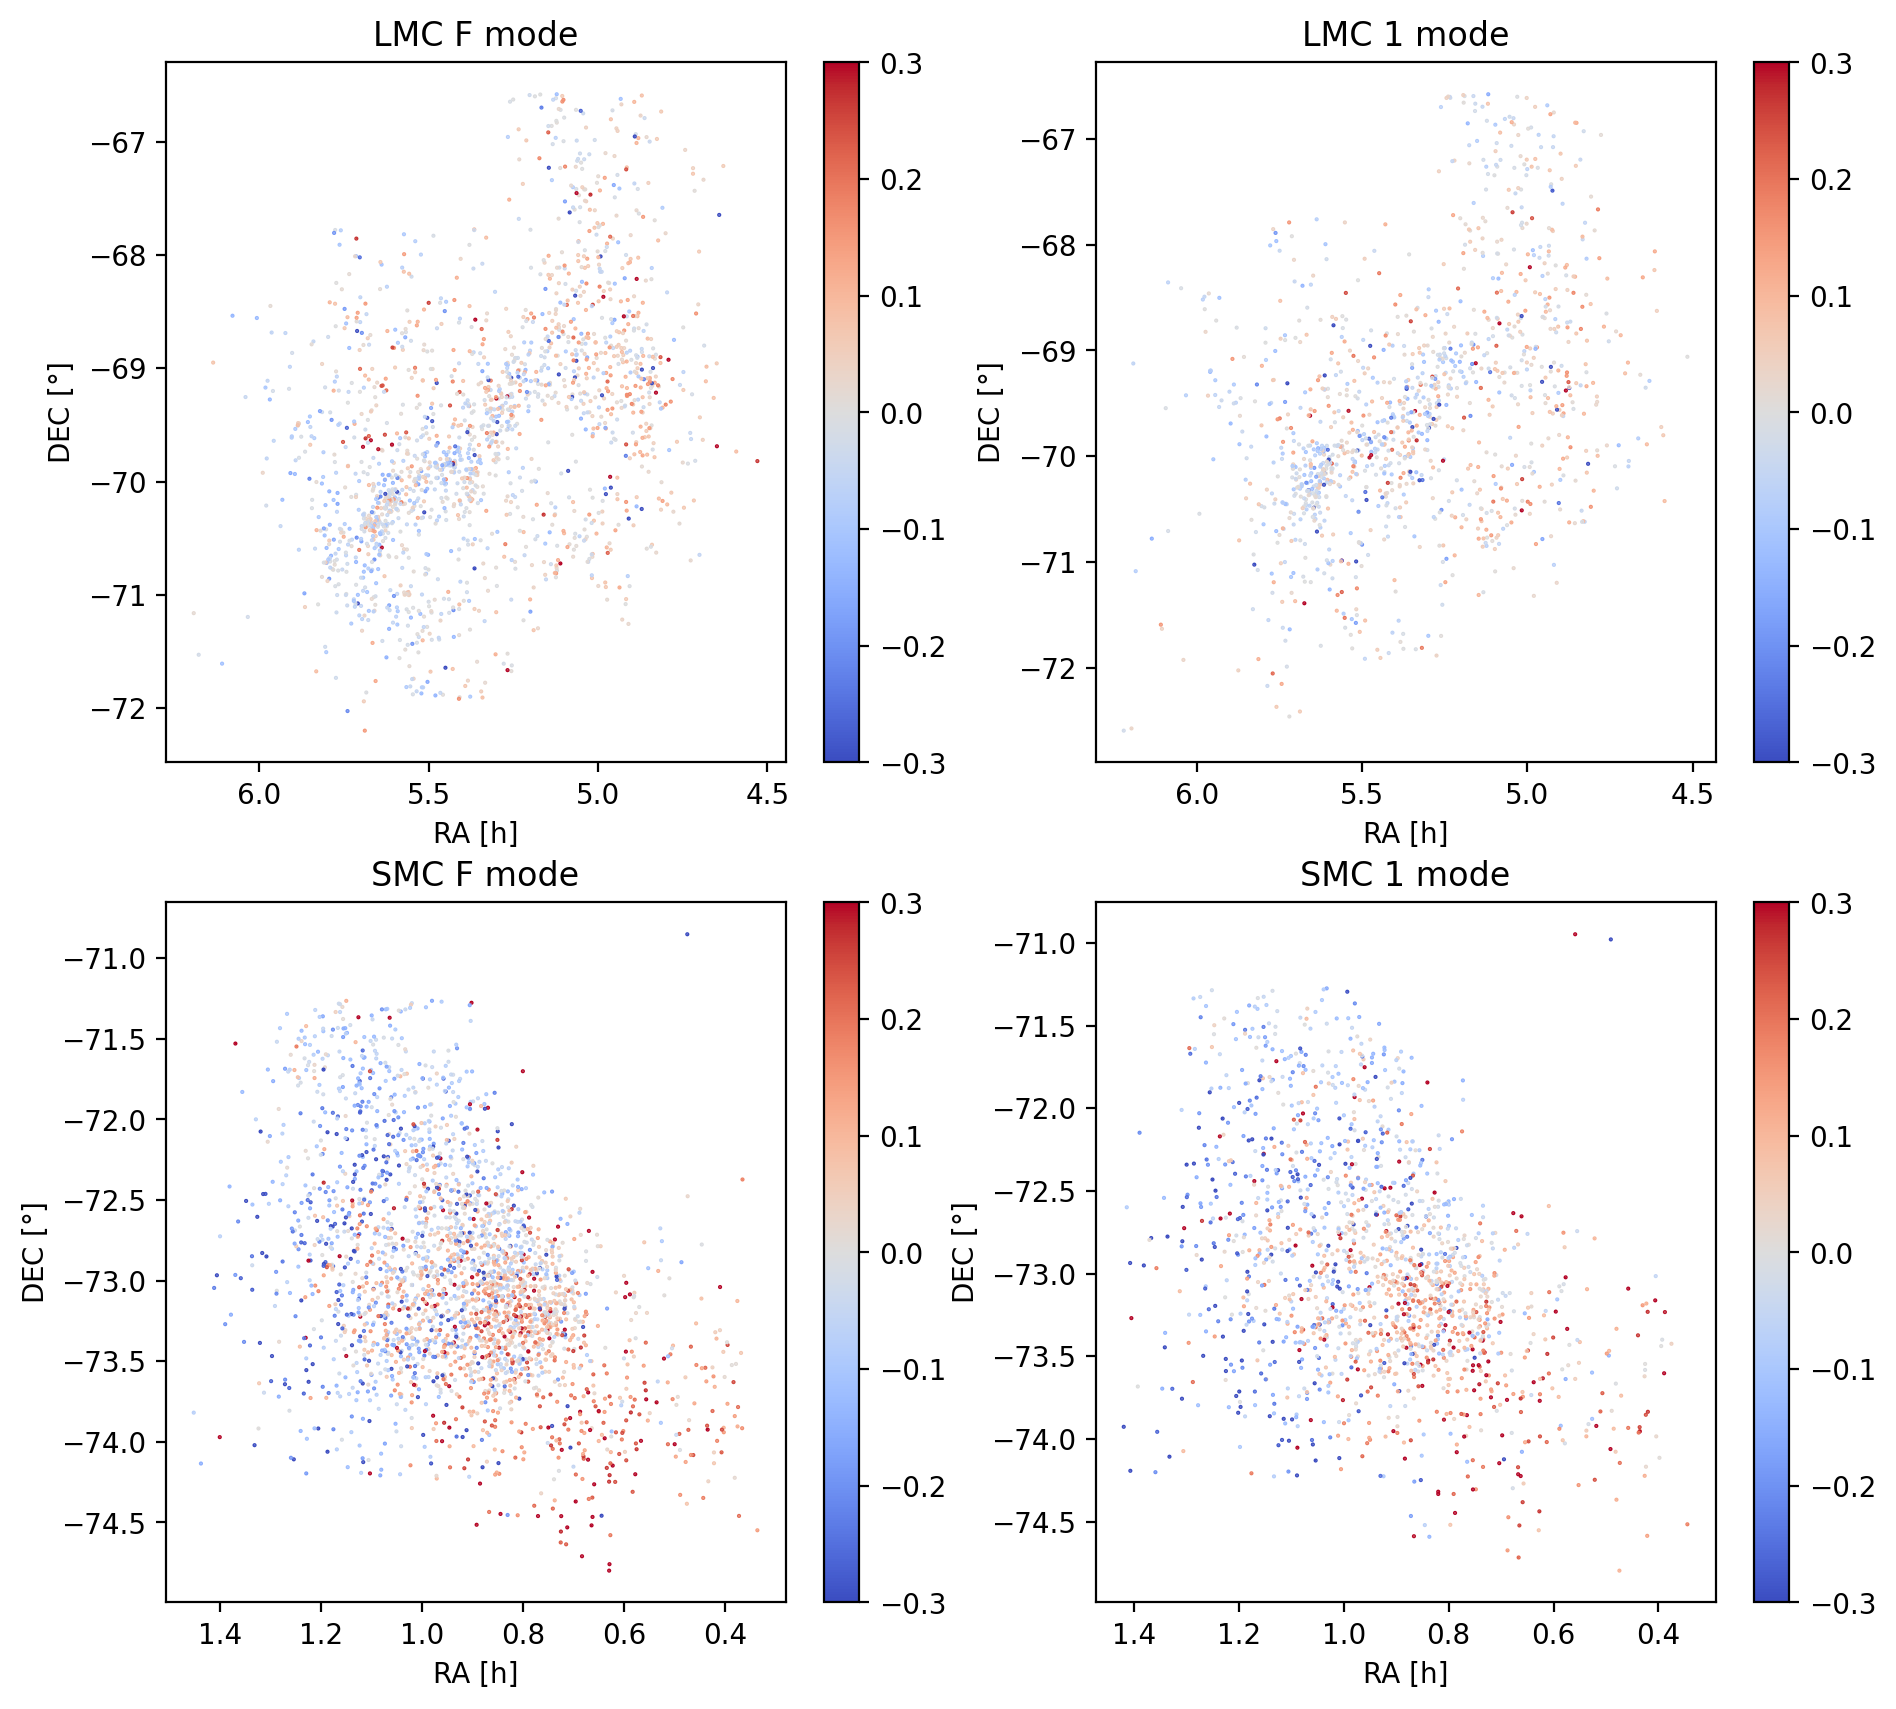

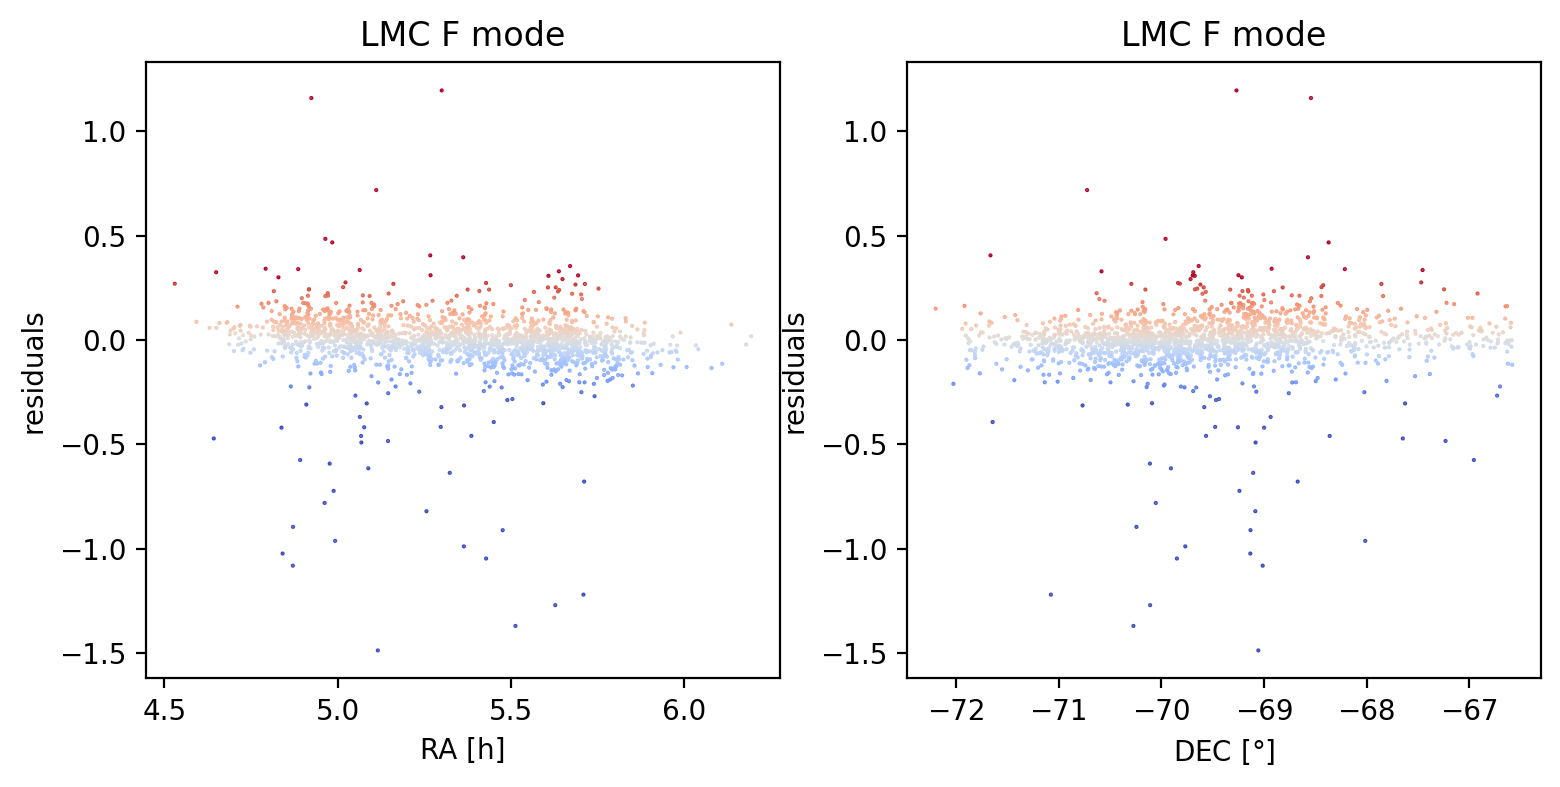

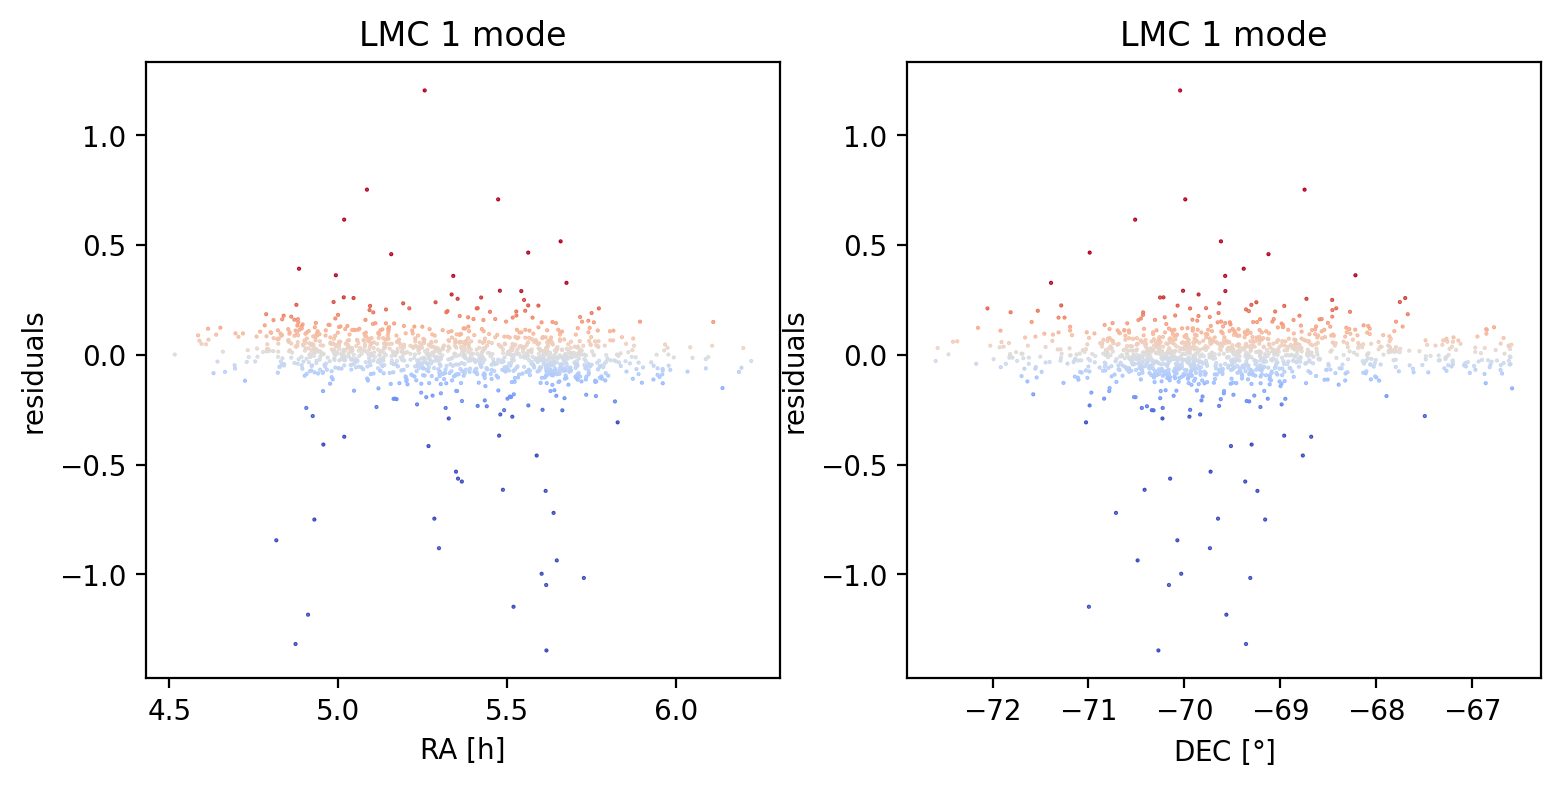

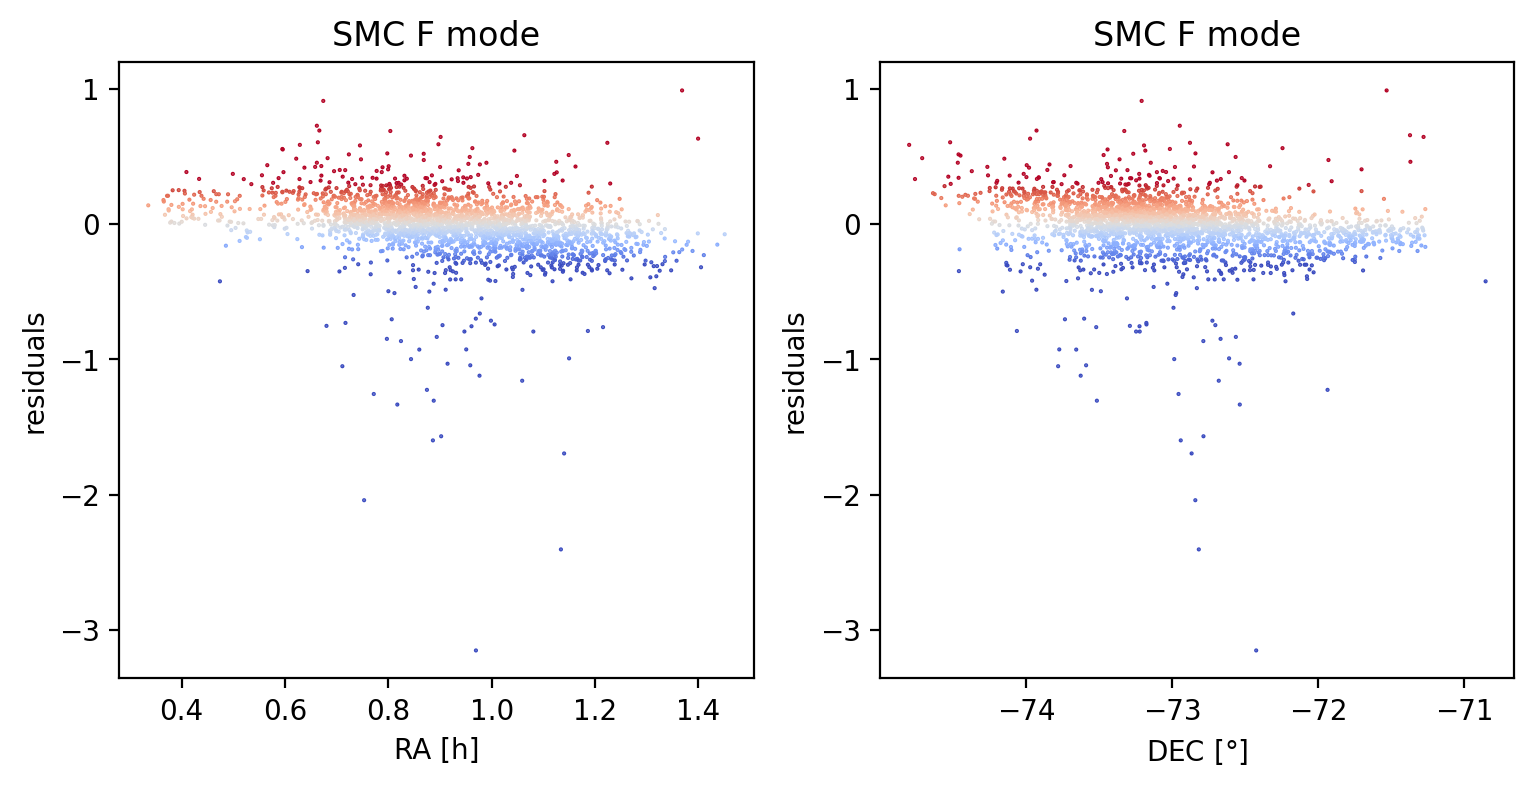

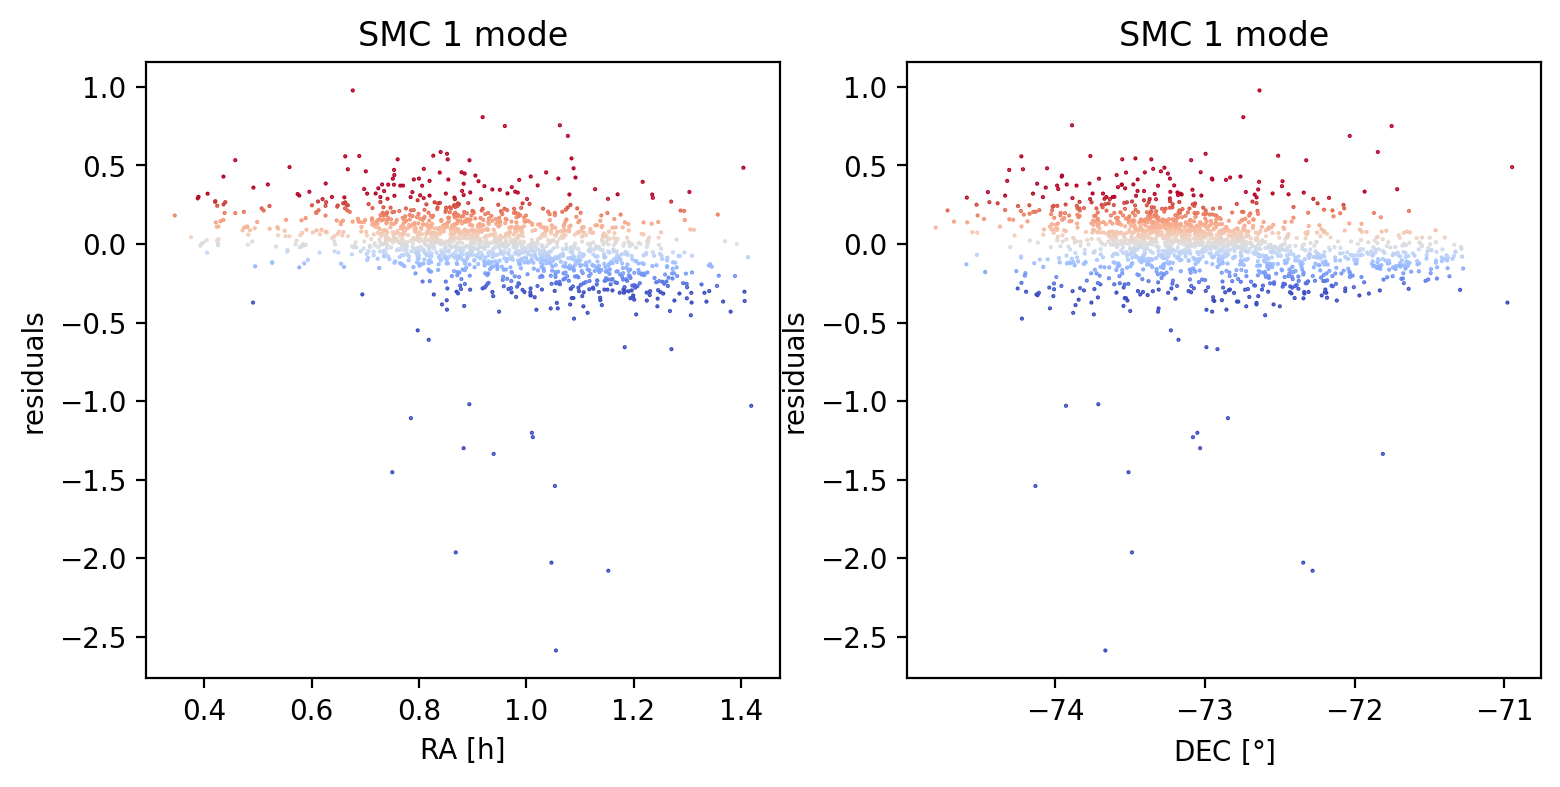

In [37]:
plt.figure(figsize=(11,10))
subplot_count = 1
cbar_lim = 0.3
for cloud in ['LMC', 'SMC']:
    for mode in ['F', '1']:
        mask = (cepheids['Cloud'] == cloud) & (cepheids['Mode'] == mode)
        resids = cepheids['W'][mask] -\
            (huber_param_out[subplot_count-1][0]*cepheids['logP1'][mask] + huber_param_out[subplot_count-1][1])
        ax = plt.subplot(2,2,subplot_count)
        sc = ax.scatter(cepheids['RA0'][mask], cepheids['Decl0'][mask], c=resids, vmin=-cbar_lim, vmax=cbar_lim,
                   cmap='coolwarm',marker='.',s=1)
        plt.colorbar(sc,ax=ax)
        plt.title('{} {} mode'.format(cloud, mode))
        plt.xlabel('RA [h]')
        plt.ylabel(r'DEC [$\degree$]')
        ax.invert_xaxis()
        subplot_count += 1
        
fit_param_enum = 0
subplot_count = 1
for cloud in ['LMC', 'SMC']:
    for mode in ['F', '1']:
        plt.figure(figsize=(9,4))
        mask = (cepheids['Cloud'] == cloud) & (cepheids['Mode'] == mode)
        resids = cepheids['W'][mask] -\
            (huber_param_out[subplot_count-1][0]*cepheids['logP1'][mask] + huber_param_out[subplot_count-1][1])
        ax = plt.subplot(1,2,1)
        sc = ax.scatter(cepheids['RA0'][mask], resids, c=resids, vmin=-cbar_lim, vmax=cbar_lim,
                   cmap='coolwarm',marker='.',s=1)
        plt.title('{} {} mode'.format(cloud, mode))
        plt.xlabel('RA [h]')
        plt.ylabel(r'residuals')
        
        ax = plt.subplot(1,2,2)
        sc = ax.scatter(cepheids['Decl0'][mask], resids, c=resids, vmin=-cbar_lim, vmax=cbar_lim,
                   cmap='coolwarm',marker='.',s=1)
        plt.title('{} {} mode'.format(cloud, mode))
        plt.xlabel(r'DEC [$\degree$]')
        plt.ylabel(r'residuals')
        subplot_count += 1
        fit_param_enum += 1

In the first set of 4 panels, I show the distribution of Cepheids in the LMC and SMC. Next are residuals vs. RA and vs. declination. In the LMC, for both modes there appears to be some trend with residuals going from positive to negative with RA, and almost no trend with declination. In the SMC, for both mode, residuals tend to go from positive to negative with both RA and DEC. The trends are not very strong, and since W is insensitive to extinction along the line of sight, we shouldn't expect the galaxy morphology to affect our measurements systematically. 

#### Finally, plot the residuals against the fitted W values, and just to anticipate the next homework assignment, also plot log(P1) vs V-I. Comment on what you are seeing. (15 pts)

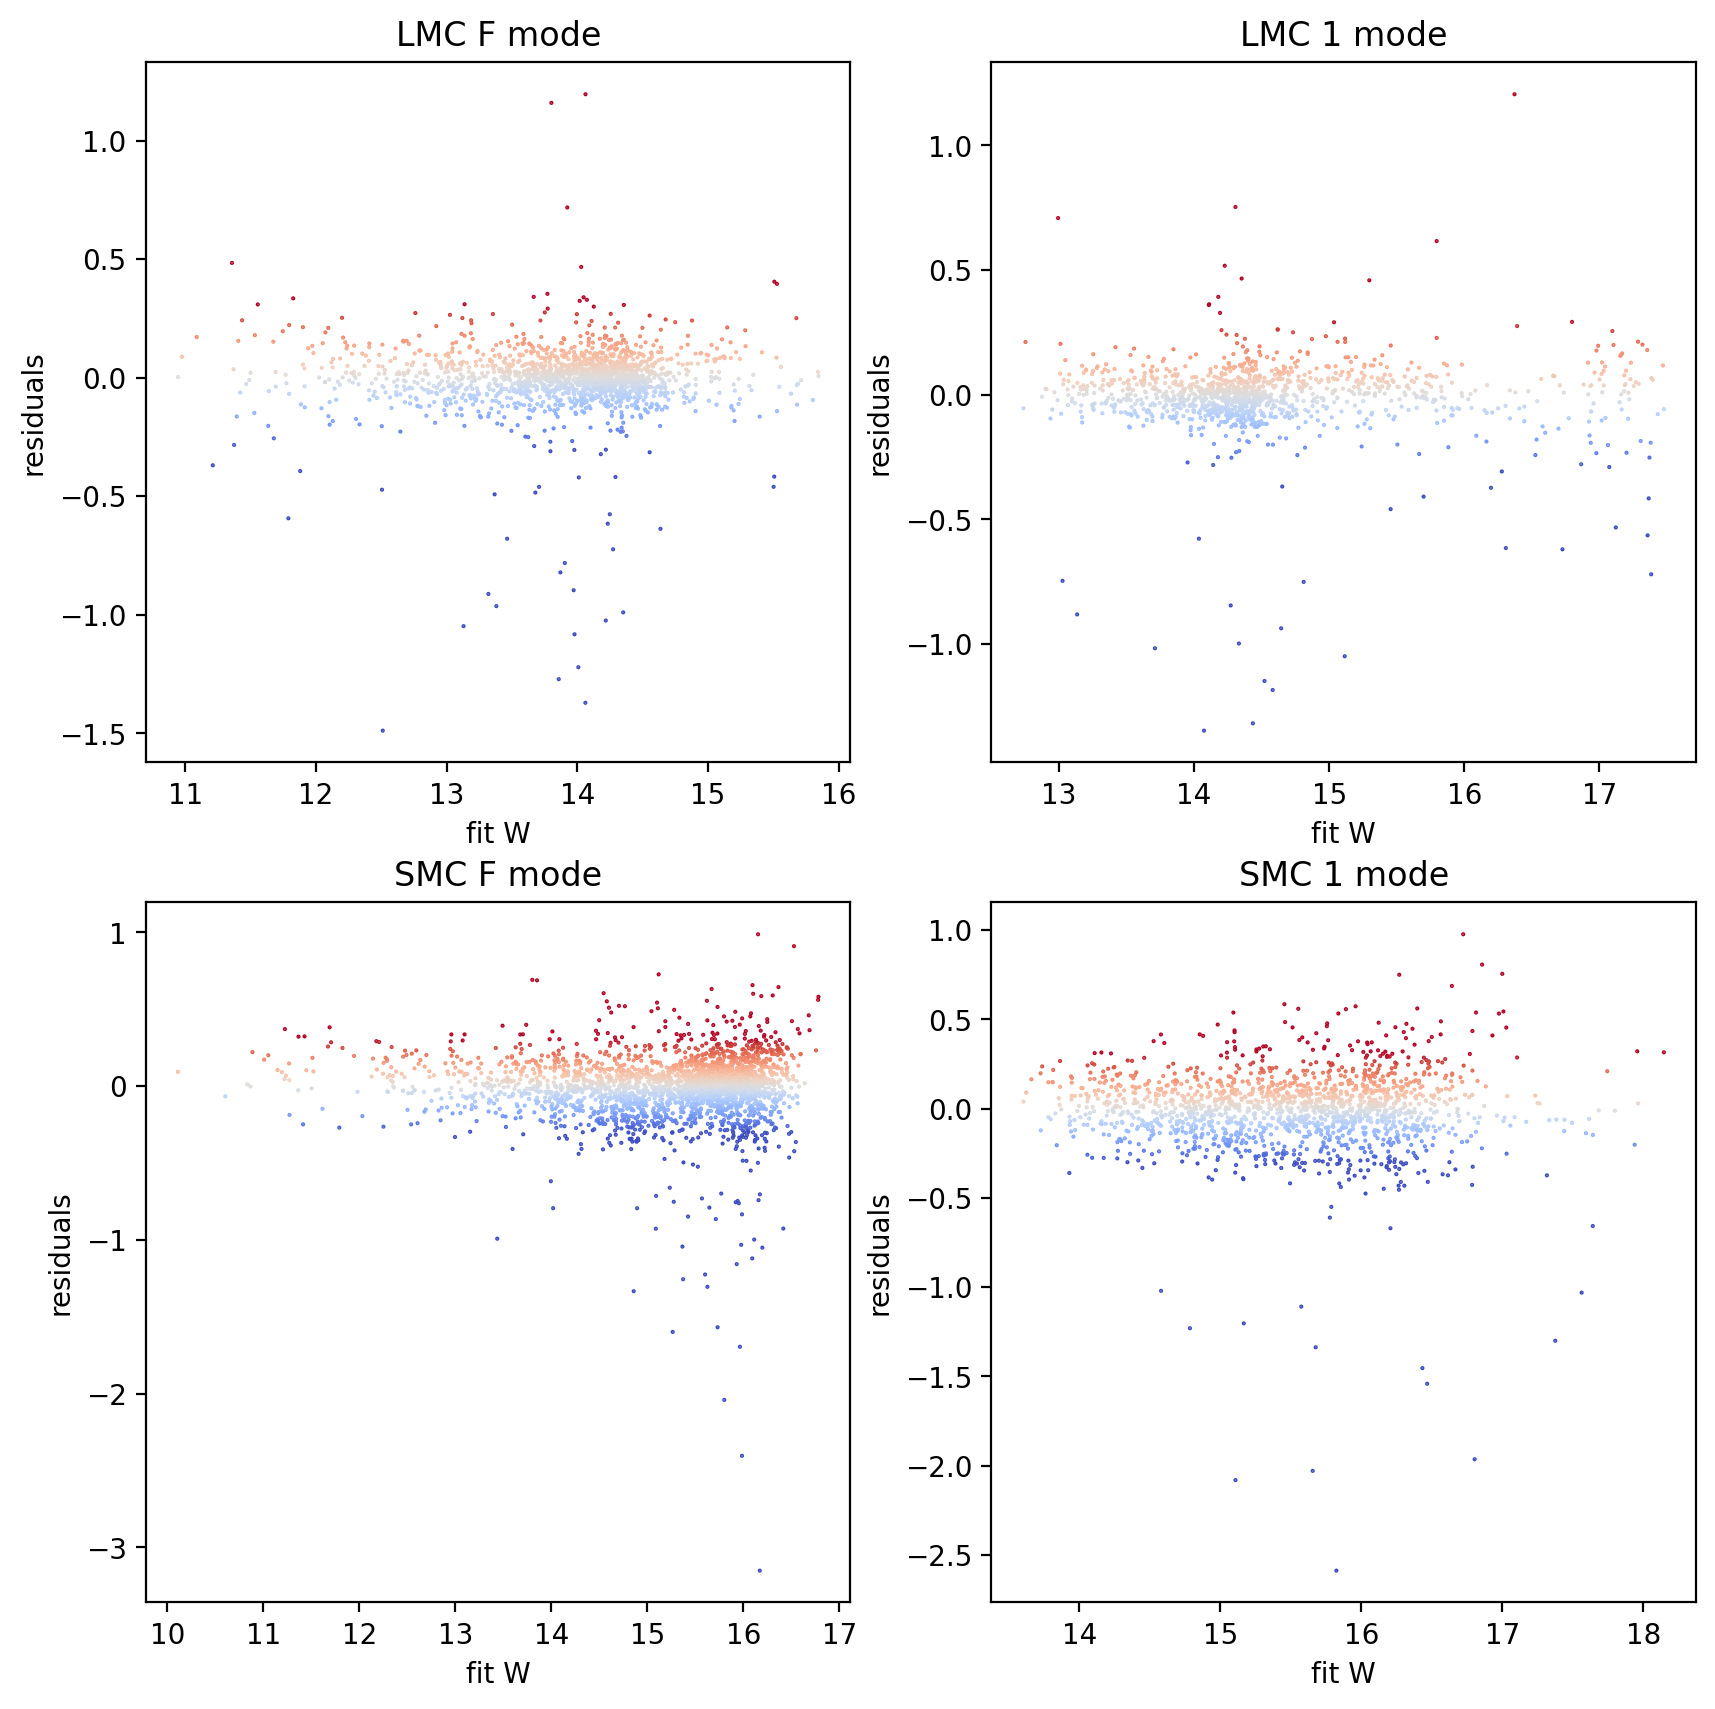

In [38]:
plt.figure(figsize=(10,10))
subplot_count = 1
for cloud in ['LMC', 'SMC']:
    for mode in ['F', '1']:
        mask = (cepheids['Cloud'] == cloud) & (cepheids['Mode'] == mode)
        resids = cepheids['W'][mask] -\
                    (huber_param_out[subplot_count-1][0]*cepheids['logP1'][mask] + huber_param_out[subplot_count-1][1])

        fit_w = (huber_param_out[subplot_count-1][0]*cepheids['logP1'][mask] + huber_param_out[subplot_count-1][1])
        plt.subplot(2,2,subplot_count)
        plt.scatter(fit_w, resids,
                   c=resids, vmin=-cbar_lim, vmax=cbar_lim,
                   cmap='coolwarm',marker='.',s=1)
        plt.title('{} {} mode'.format(cloud, mode))
        plt.xlabel('fit W')
        plt.ylabel('residuals')
        subplot_count += 1

There aren't any immediately obvious trends of residual with the fit to W, but these figures make it clear that there is a lot of clustering of Cepheids around particular periods (fit Ws), and that a large fraction of the strong outliers reside there. In the SMC, these are W $\sim 14$, and W $\sim 16$ in the SMC.

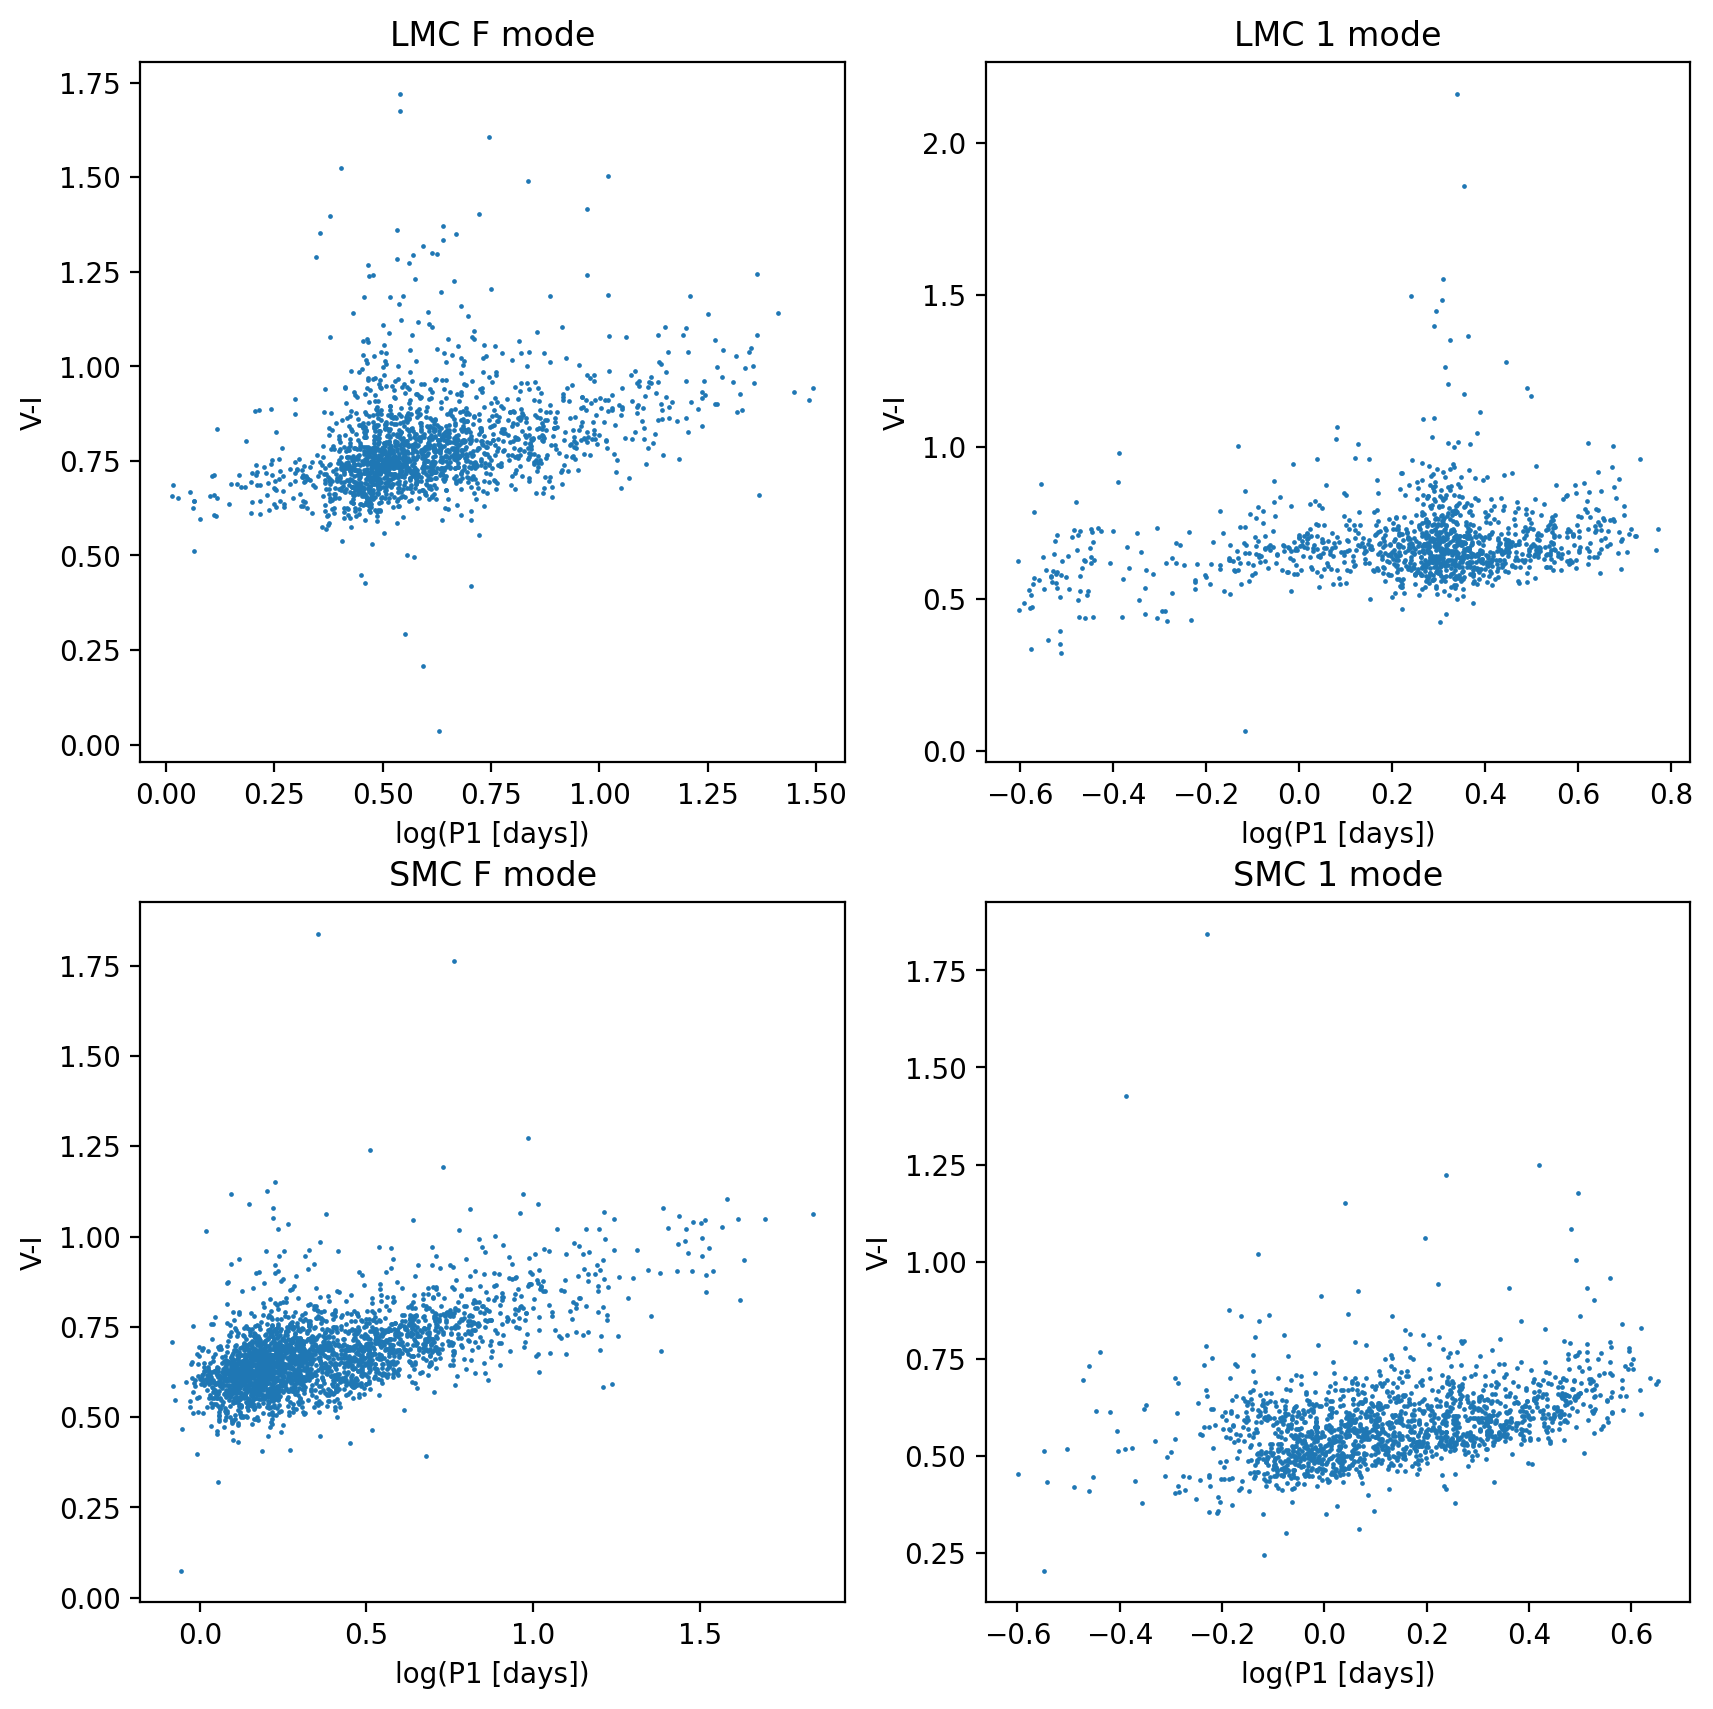

In [39]:
plt.figure(figsize=(10,10))
subplot_count = 1
for cloud in ['LMC', 'SMC']:
    for mode in ['F', '1']:
        mask = (cepheids['Cloud'] == cloud) & (cepheids['Mode'] == mode)
        p1 = cepheids['logP1'][mask]
        VI = cepheids['VI'][mask]
        plt.subplot(2,2,subplot_count)
        plt.scatter(p1, VI,marker='.',s=2)
        plt.title('{} {} mode'.format(cloud, mode))
        plt.xlabel('log(P1 [days])')
        plt.ylabel('V-I')
        subplot_count += 1

Like with W, we do see some hints of a period-luminosity relationship when using V-I, but there is significantly more scatter in V-I. I expect that V-I color is less robust against dust extinction than W, so for a given period, the column of dust between us and the particular Cepheid systematically offsets the V-I color from a best-fit line. Also note that the scatter is not normally distributed, but rather unidirectional. Since dust reddens, but doesn't "blue-en", this non-normal residual is expected from a magnitude sensistive to dust extinction. 

For both the LMC and SMC, the F mode Cepheids have shorter periods than the 1 mode Cepheids.